In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import os

In [2]:
def generate_data():
    df = pd.read_csv(Path(r'C:/\Users/\vchar/\OneDrive/\Desktop/\ML Projects/\Upwork/\AlgoT_ML_Dev/\GrammarEvolution/\PonyGE2/\datasets/\BTCUSD_ohlcv.csv'))
    # df = pd.read_csv('/kaggle/input/btcusd-test/BTCUSD_ohlcv.csv')
    df['datetime'] = pd.to_datetime(df['datetime'])
    df = df.iloc[-10080:]
    df.sort_values('datetime', ascending=True, inplace=True)
    df.reset_index(inplace=True, drop=True)
    return df

In [3]:
data = generate_data()
data.head()

,datetime,open,high,low,close,volume
0,2022-12-30 20:45:00,16534.6,16537.5,16534.6,16537.5,36187.0
1,2022-12-30 20:46:00,16537.5,16538.2,16535.6,16538.2,101860.0
2,2022-12-30 20:47:00,16538.2,16538.2,16538.1,16538.2,102265.0
3,2022-12-30 20:48:00,16538.2,16538.4,16538.1,16538.2,71347.0
4,2022-12-30 20:49:00,16538.2,16538.2,16535.8,16535.9,57985.0


# Indicators

In [4]:
import pandas as pd
import numpy as np
from numba import prange, njit, types
from numba.typed import Dict
import pandas_ta as ta
import itertools
import gc
import time
from scipy.stats import norm, iqr, chi2, chi2_contingency

import warnings
warnings.filterwarnings('ignore')

In [5]:
def normalize_observation(x, x_median, x_iqr, is_centered=True, is_scaled=True):

    if is_centered:
        new_x = x - x_median
    else:
        new_x = x.copy()

    if is_scaled:
        new_x = 100 * norm.cdf(0.25 * new_x / x_iqr) - 50
    else:
        pass

    return new_x

# Creating functions for trend indicators/variables

def MA_DIFFERENCE(df, ShortLength, LongLength, Lag):
    short_ma = ta.sma(df['close'], length=ShortLength)
    long_ma = ta.sma(df['close'].shift(Lag), length=LongLength)
    ma_diff = short_ma - long_ma
    df_atr = ta.atr(high=df['high'], low=df['low'], close=df['close'], length=LongLength+Lag)
    df_stat = ma_diff / df_atr
    period = LongLength+Lag
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['MA_Diff']
    return df_stat

def get_ls_slope(y, length):
    # X = np.vstack([np.arange(1, length+1), np.ones(length, dtype='int')]).T
    # m, c = np.linalg.lstsq(X, y, rcond=None)[0]
    x = np.arange(1, length+1)
    # np.polyfit(x, y, 1)
    return np.polyfit(x, y, 1)[0] #m #* np.arange(1, length+1) + c

def LINEAR_PER_ATR(df, HistLength, ATRlength):
    df_log_mean = np.log(df[['high', 'low', 'open', 'close']].mean(axis=1))
    df_atr = ta.atr(high=df['high'], low=df['low'], close=df['close'], length=ATRlength)
    df_slope = df_log_mean.rolling(window=HistLength).apply(lambda x: get_ls_slope(y=x, length=len(x)))
    df_stat = df_slope / df_atr
    period = HistLength
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Price_Velocity']
    return df_stat

def get_quad_slope(y, length):
    # X = np.vstack([np.arange(1, length+1), np.ones(length, dtype='int')]).T
    # m, c = np.linalg.lstsq(X, y, rcond=None)[0]
    x = np.arange(1, length+1)
    # np.polyfit(x, y, 1)
    return np.polyfit(x, y, 2)[0] #m #* np.arange(1, length+1) + c

def QUADRATIC_PER_ATR(df, HistLength, ATRlength):
    df_log_mean = np.log(df[['high', 'low', 'open', 'close']].mean(axis=1))
    df_atr = ta.atr(high=df['high'], low=df['low'], close=df['close'], length=ATRlength)
    df_slope = df_log_mean.rolling(window=HistLength).apply(lambda x: get_quad_slope(y=x, length=len(x)))
    df_stat = df_slope / df_atr
    period = HistLength
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Price_Acceleration']
    return df_stat

def get_cubic_slope(y, length):
    # X = np.vstack([np.arange(1, length+1), np.ones(length, dtype='int')]).T
    # m, c = np.linalg.lstsq(X, y, rcond=None)[0]
    x = np.arange(1, length+1)
    # np.polyfit(x, y, 1)
    return np.polyfit(x, y, 3)[0] #m #* np.arange(1, length+1) + c

def CUBIC_PER_ATR(df, HistLength, ATRlength):
    df_log_mean = np.log(df[['high', 'low', 'open', 'close']].mean(axis=1))
    df_atr = ta.atr(high=df['high'], low=df['low'], close=df['close'], length=ATRlength)
    df_slope = df_log_mean.rolling(window=HistLength).apply(lambda x: get_cubic_slope(y=x, length=len(x)))
    df_stat = df_slope / df_atr
    period = HistLength
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Acceleration_Rate_of_Change']
    return df_stat

def RSI(df, HistLength):
    rsi_df = ta.rsi(df['close'], length=HistLength).to_frame()
    rsi_df.columns = ['RSI']
    return rsi_df

def STOCHASTIC_K(df, fastk_period, slowk_period, slowd_period):

	df_stat = ta.stoch(
		df["high"], df["low"], df["close"], 
		fastk_period, slowk_period, slowd_period)[f'STOCHk_{fastk_period}_{slowk_period}_{slowd_period}']
	df_stat = df_stat.to_frame()
	df_stat.columns = ['STOCHASTIC_K']
	return df_stat

def STOCHASTIC_D(df, fastk_period, slowk_period, slowd_period):
	df_stat = ta.stoch(
		df["high"], df["low"], df["close"], 
		fastk_period, slowk_period, slowd_period)[f'STOCHd_{fastk_period}_{slowk_period}_{slowd_period}']
	df_stat = df_stat.to_frame()
	df_stat.columns = ['STOCHASTIC_D']
	return df_stat

def PRICE_MOMENTUM(df, HistLength, StdDevLength):

    df_stat = df['close'] / df['close'].shift(HistLength)
    df_std = df['close'].rolling(window=StdDevLength).std()
    df_stat = df_stat / df_std
    period = HistLength
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Price_Momentum']
    return df_stat

def ADX(df, HistLength):
	df_stat = ta.adx(
		high=df['high'], 
		low=df['low'], 
		close=df['close'], 
		length=HistLength
	)[f'ADX_{HistLength}']

	df_stat = df_stat.to_frame()
	df_stat.columns = ['ADX']
	return df_stat

def MIN_ADX(df, HistLength, MinLength):

    adx_list = []

    for i in range(MinLength):
        temp_adx = ta.adx(
            high=df['high'].shift(i), 
            low=df['low'].shift(i), 
            close=df['close'].shift(i), 
            length=HistLength
        )[f'ADX_{HistLength}']

        adx_list.append(temp_adx.values)

    df_stat = pd.Series(np.min(np.array(adx_list), axis=0), index=temp_adx.index)
    df_stat = df_stat.to_frame()  
    df_stat.columns = ['Min_ADX']
    return df_stat

def RESIDUAL_MIN_ADX(df, HistLength, MinLength):

    current_adx = ta.adx(
        high=df['high'], 
        low=df['low'], 
        close=df['close'], 
        length=HistLength
    )[f'ADX_{HistLength}']

    min_adx = MIN_ADX(df, HistLength, MinLength)

    df_stat = current_adx - min_adx

    return df_stat

def MAX_ADX(df, HistLength, MaxLength):

    adx_list = []

    for i in range(MaxLength):
        temp_adx = ta.adx(
            high=df['high'].shift(i), 
            low=df['low'].shift(i), 
            close=df['close'].shift(i), 
            length=HistLength
        )[f'ADX_{HistLength}']

        adx_list.append(temp_adx.values)

    df_stat = pd.DataFrame(np.max(np.array(adx_list), axis=0), index=df.index)
    df_stat.columns = ['MAX_ADX']
    return df_stat

def RESIDUAL_MAX_ADX(df, HistLength, MaxLength):

    current_adx = ta.adx(
        high=df['high'], 
        low=df['low'], 
        close=df['close'], 
        length=HistLength
    )[f'ADX_{HistLength}']

    max_adx = MAX_ADX(df, HistLength, MaxLength)

    df_stat = max_adx - current_adx

    return df_stat

def DELTA_ADX(df, HistLength,  DeltaLength):

    current_adx = ta.adx(
        high=df['high'], 
        low=df['low'], 
        close=df['close'], 
        length=HistLength
    )[f'ADX_{HistLength}']

    lag_adx = ta.adx(
        high=df['high'].shift(DeltaLength), 
        low=df['low'].shift(DeltaLength), 
        close=df['close'].shift(DeltaLength), 
        length=HistLength
    )[f'ADX_{HistLength}']

    df_stat = current_adx - lag_adx
    period = HistLength
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['ADX_Velocity']
    return df_stat

def ACCEL_ADX(df, HistLength, DeltaLength):

    current_adx = ta.adx(
        high=df['high'], 
        low=df['low'], 
        close=df['close'], 
        length=HistLength
    )[f'ADX_{HistLength}']

    lag_adx1 = ta.adx(
        high=df['high'].shift(DeltaLength), 
        low=df['low'].shift(DeltaLength), 
        close=df['close'].shift(DeltaLength), 
        length=HistLength
    )[f'ADX_{HistLength}']

    lag_adx2 = ta.adx(
        high=df['high'].shift(2*DeltaLength), 
        low=df['low'].shift(2*DeltaLength), 
        close=df['close'].shift(2*DeltaLength), 
        length=HistLength
    )[f'ADX_{HistLength}']

    df_stat = current_adx + lag_adx2 - 2 * lag_adx1
    period = HistLength
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['ADX_Acceleration']
    return df_stat

def INTRADAY_INTENSITY(df, HistLength):

    diff1 = df['high'] - df['low']
    diff2 = df['high'] - df['close'].shift(1)
    diff3 = df['close'].shift(1) - df['low']

    true_range = np.max(
        np.array(
            [
                diff1.values, 
                diff2.values, 
                diff3.values
             ]
        ), 
    axis=0
    )

    current_change = df['close'] - df['open']

    df_stat = current_change / true_range
    df_stat = df_stat.rolling(window=HistLength).mean()
    period = HistLength
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Intraday_Intensity']
    return df_stat

def DELTA_INTRADAY_INTENSITY(df, HistLength, DeltaLength):

    current_inten = INTRADAY_INTENSITY(df, HistLength)
    lag_inten = INTRADAY_INTENSITY(df=df.shift(DeltaLength), HistLength=HistLength)
    df_stat = current_inten - lag_inten
    df_stat.columns = ['Delta_Intraday_Intensity']
    return df_stat

def REACTIVITY(df, HistLength):

    price_change = df['close'] - df['close'].shift(HistLength)

    max_price = df['high'].rolling(window=HistLength).max()
    min_price = df['low'].rolling(window=HistLength).min()
    price_range = max_price - min_price

    total_volume = df['volume'].rolling(window=HistLength).sum()

    ema_price_range = ta.ema(close=price_range, length=8*HistLength)
    ema_total_volume = ta.ema(close=total_volume, length=8*HistLength)
    aspect_ratio = (price_range / ema_price_range) / (total_volume / ema_total_volume)

    raw_reactivity = price_change * aspect_ratio
    df_stat = raw_reactivity / ema_price_range
    period = HistLength
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Reactivity']
    return df_stat

def DELTA_REACTIVITY(df, HistLength, DeltaDist):

    current_reactivity = REACTIVITY(df, HistLength)
    lag_reactivity = REACTIVITY(df=df.shift(DeltaDist), HistLength=HistLength)

    stat_values = (current_reactivity - lag_reactivity).values.reshape(-1, )

    df_stat = pd.Series(stat_values, index=df.index)
    period = HistLength
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Delta_Reactivity']
    return df_stat

def MIN_REACTIVITY(df, HistLength, Dist):

    reactivity_list = []
    for i in range(Dist):
        reactivity_list.append(REACTIVITY(df=df.shift(i), HistLength=HistLength).values)

    stat_values = np.min(np.array(reactivity_list), axis=0).reshape(-1, )

    df_stat = pd.Series(stat_values, index=df.index)
    period = HistLength
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Min_Reactivity']
    return df_stat

def MAX_REACTIVITY(df, HistLength, Dist):

    reactivity_list = []
    for i in range(Dist):
        reactivity_list.append(REACTIVITY(df=df.shift(i), HistLength=HistLength).values)

    stat_values = np.max(np.array(reactivity_list), axis=0).reshape(-1, )

    df_stat = pd.Series(stat_values, index=df.index)
    period = HistLength
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Max_Reactivity']
    return df_stat

# Creating functions for trend like indicators/variables

def CLOSE_TO_CLOSE(df):

    df_stat = 100 * np.log(df['close'] / df['close'].shift(1))
    df_stat = df_stat.to_frame()
    df_stat.columns = ['Close_to_Close']
    return df_stat

@njit
def get_n_day_high(x, y):

    N = len(x) + 1

    for i in prange(len(x)-1, -1, -1):
        if x[i] > y:
            N = i + 1
            break
        else:
            pass

    return 100 * (N-1) / len(x) - 50

@njit
def get_hist_values(x, length):

    hist_values = []

    for i in prange(length, len(x)+1):

        hist_values.append(x[i-length: i])

    return hist_values

def N_DAY_HIGH(df, HistLength):

    list_of_values = get_hist_values(x=df['high'].values, length=HistLength)
    # df['high'].rolling(window=HistLength, closed='left').apply(
    #     lambda x: list_of_values.append(x.values) or 0, 
    #     raw=False
    # )

    temp_df = pd.Series(list_of_values, index=df.iloc[HistLength-1:].index)
    temp_df = temp_df.to_frame()
    temp_df.columns = ['high_list']
    temp_df['high'] = df.iloc[HistLength:]['high']

    df_stat = temp_df.apply(lambda x: get_n_day_high(x=x['high_list'], y=x['high']), axis=1)
    df_stat = df_stat.to_frame()
    df_stat.columns = ['N_Day_High']
    return df_stat

@njit
def get_n_day_low(x, y):

    N = len(x) + 1

    for i in prange(len(x)-1, -1, -1):
        if x[i] < y:
            N = i + 1
            break
        else:
            pass

    return 100 * (N-1) / len(x) - 50

def N_DAY_LOW(df, HistLength):

    list_of_values = get_hist_values(x=df['low'].values, length=HistLength)
    # df['low'].rolling(window=HistLength, closed='left').apply(
    #     lambda x: list_of_values.append(x.values) or 0, 
    #     raw=False
    # )

    temp_df = pd.Series(list_of_values, index=df.iloc[HistLength-1:].index)
    temp_df = temp_df.to_frame()
    temp_df.columns = ['low_list']
    temp_df['low'] = df.iloc[HistLength:]['low']

    df_stat = temp_df.apply(lambda x: get_n_day_low(x=x['low_list'], y=x['low']), axis=1)
    df_stat = df_stat.to_frame()
    df_stat.columns = ['N_Day_Low']
    return df_stat

# Creating functions for indicators/variables of deviations from trend

def CLOSE_MINUS_MOVING_AVERAGE(df, HistLen, ATRlen):

    close_ratio = np.log(df['close'] / df['close'].rolling(window=HistLen).mean())
    atr = ta.atr(high=df['high'], low=df['low'], close=df['close'], length=ATRlen)
    df_stat = close_ratio / atr
    period = HistLen
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['CMMA']
    return df_stat

def get_ls_fit(y):
    length = len(y)
    x = np.arange(1, length+1)
    result = np.polyfit(x, y, 1)
    y_fit = result[1] + length * result[0]
    std_dev = np.sum((y - y_fit)**2)
    std_error = (std_dev / (length-1)) ** 0.5
    return [y_fit, std_error]

def LINEAR_DEVIATION(df, HistLength):

    df_log_mean = np.log(df[['high', 'low', 'open', 'close']].mean(axis=1))

    list_of_values = get_hist_values(x=df_log_mean.values, length=HistLength)
    # df_log_mean.rolling(window=HistLength, closed='both').apply(
    #     lambda x: list_of_values.append(x.values) or 0, 
    #     raw=False
    # )

    temp_df = pd.Series(list_of_values, index=df.iloc[HistLength-1:].index)
    temp_df = temp_df.apply(lambda x: get_ls_fit(y=x))
    temp_df = pd.DataFrame(temp_df.to_list(), columns=['fit','std_error'])
    temp_df.index = df.iloc[HistLength-1:].index
    temp_df['log_price'] = df_log_mean.iloc[HistLength-1:]

    df_stat = (temp_df['log_price'] - temp_df['fit']) / temp_df['std_error']
    period = HistLength
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Linear_Deviation']
    return df_stat

def get_quadratic_fit(y):
    length = len(y)
    x = np.arange(1, length+1)
    result = np.polyfit(x, y, 2)
    y_fit = result[2] + length * result[1] + (length**2) * result[0]
    std_dev = np.sum((y - y_fit)**2)
    std_error = (std_dev / (length-1)) ** 0.5
    return [y_fit, std_error]

def QUADRATIC_DEVIATION(df, HistLength):

    df_log_mean = np.log(df[['high', 'low', 'open', 'close']].mean(axis=1))

    # list_of_values = []
    # df_log_mean.rolling(window=HistLength, closed='both').apply(
    #     lambda x: list_of_values.append(x.values) or 0, 
    #     raw=False
    # )
    list_of_values = get_hist_values(x=df_log_mean.values, length=HistLength)

    temp_df = pd.Series(list_of_values, index=df.iloc[HistLength-1:].index)
    temp_df = temp_df.apply(lambda x: get_quadratic_fit(y=x))
    temp_df = pd.DataFrame(temp_df.to_list(), columns=['fit','std_error'])
    temp_df.index = df.iloc[HistLength-1:].index
    temp_df['log_price'] = df_log_mean.iloc[HistLength-1:]

    df_stat = (temp_df['log_price'] - temp_df['fit']) / temp_df['std_error']
    period = HistLength
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Quadratic_Deviation']
    return df_stat

def get_cubic_fit(y):
    length = len(y)
    x = np.arange(1, length+1)
    result = np.polyfit(x, y, 3)
    y_fit = result[3] + length * result[2] + (length**2) * result[1] + (length**3) * result[0]
    std_dev = np.sum((y - y_fit)**2)
    std_error = (std_dev / (length-1)) ** 0.5
    return [y_fit, std_error]

def CUBIC_DEVIATION(df, HistLength):

    df_log_mean = np.log(df[['high', 'low', 'open', 'close']].mean(axis=1))

    # list_of_values = []
    # df_log_mean.rolling(window=HistLength, closed='both').apply(
    #     lambda x: list_of_values.append(x.values) or 0, 
    #     raw=False
    # )
    list_of_values = get_hist_values(x=df_log_mean.values, length=HistLength)

    temp_df = pd.Series(list_of_values, index=df.iloc[HistLength-1:].index)
    temp_df = temp_df.apply(lambda x: get_cubic_fit(y=x))
    temp_df = pd.DataFrame(temp_df.to_list(), columns=['fit','std_error'])
    temp_df.index = df.iloc[HistLength-1:].index
    temp_df['log_price'] = df_log_mean.iloc[HistLength-1:]

    df_stat = (temp_df['log_price'] - temp_df['fit']) / temp_df['std_error']
    period = HistLength
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Cubic_Deviation']
    return df_stat

def get_ls_fit2(x, y):
    result = np.polyfit(x, y, 1)
    y_fit = result[1] + x[-1] * result[0]
    return y_fit

def DETRENDED_RSI(df, DetrendedLength, DetrenderLength, Lookback):

    rsi_y = ta.rsi(df['close'], length=DetrendedLength)

    if DetrendedLength == 2:
        rsi_y = 1 / (1 + np.exp(-rsi_y))

    rsi_x = ta.rsi(df['close'], length=DetrenderLength)

    rsi_array = np.vstack([rsi_y.values, rsi_x.values]).T
    rsi_df = pd.DataFrame(rsi_array, columns=['rsi_y', 'rsi_x'], index=rsi_y.index)
    rsi_df.dropna(inplace=True)

    # list_of_rsi_y = []
    # rsi_df['rsi_y'].rolling(window=Lookback, closed='both').apply(
    #     lambda x: list_of_rsi_y.append(x.values) or 0, 
    #     raw=False
    # )
    list_of_rsi_y = get_hist_values(x=rsi_df['rsi_y'].values, length=Lookback)

    # list_of_rsi_x = []
    # rsi_df['rsi_x'].rolling(window=Lookback, closed='both').apply(
    #     lambda x: list_of_rsi_x.append(x.values) or 0, 
    #     raw=False
    # )
    list_of_rsi_x = get_hist_values(x=rsi_df['rsi_x'].values, length=Lookback)

    temp_df = pd.Series(list_of_rsi_x, index=df.iloc[Lookback-1+DetrenderLength:].index)
    temp_df = temp_df.to_frame()
    temp_df.columns = ['rsi_x']
    temp_df['rsi_y'] = list_of_rsi_y

    temp_df['fit'] = temp_df.apply(lambda x: get_ls_fit2(x=x['rsi_x'], y=x['rsi_y']), axis=1)
    temp_df['rsi_y'] = rsi_y.iloc[Lookback-1:]

    df_stat = (temp_df['rsi_y'] - temp_df['fit'])
    df_stat = df_stat.to_frame()
    df_stat.columns = ['Detrended_RSI']
    return df_stat

# Creating functions for volatility indicators/variables

def ABS_PRICE_CHANGE_OSCILLATOR(df, ShortLen, Multiplier):

    price_changes = np.abs(np.log(df['close']/df['close'].shift(1)))
    short_ma = price_changes.rolling(window=ShortLen).mean()
    long_ma = price_changes.rolling(window=ShortLen*Multiplier).mean()
    atr = ta.atr(high=df['high'], low=df['low'], close=df['close'], length=ShortLen*Multiplier)
    df_stat = (short_ma - long_ma) / atr
    period = ShortLen
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['APCO']
    return df_stat

def PRICE_VARIANCE_RATIO(df, HistLength, Multiplier):

    log_prices = np.log(df['close'])
    short_var = log_prices.rolling(window=HistLength).var()
    long_var = log_prices.rolling(window=HistLength*Multiplier).var()
    df_stat = short_var / long_var
    period = HistLength
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['PVR']
    return df_stat

def MIN_PRICE_VARIANCE_RATIO(df, HistLen, Mult, Mlength):

    pvr_list = []

    for i in range(Mlength):

        pvr_list.append(PRICE_VARIANCE_RATIO(df=df.shift(i), HistLength=HistLen, Multiplier=Mult))

    df_stat = np.min(np.array(pvr_list), axis=0)
    df_stat = pd.DataFrame(df_stat, index=df.index)
    df_stat.columns = ['MinPVR']
    return df_stat

def MAX_PRICE_VARIANCE_RATIO(df, HistLen, Mult, Mlength):

    pvr_list = []

    for i in range(Mlength):

        pvr_list.append(PRICE_VARIANCE_RATIO(df=df.shift(i), HistLength=HistLen, Multiplier=Mult))

    df_stat = np.max(np.array(pvr_list), axis=0)
    df_stat = pd.DataFrame(df_stat, index=df.index)
    df_stat.columns = ['MaxPVR']
    return df_stat

def CHANGE_VARIANCE_RATIO(df, HistLength, Multiplier):

    log_prices = np.log(df['close']/df['close'].shift(1))
    short_var = log_prices.rolling(window=HistLength).var()
    long_var = log_prices.rolling(window=HistLength*Multiplier).var()
    df_stat = short_var / long_var
    period = HistLength
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['CVR']
    return df_stat

def MIN_CHANGE_VARIANCE_RATIO(df, HistLen, Mult, Mlen):

    pvr_list = []

    for i in range(Mlen):

        pvr_list.append(CHANGE_VARIANCE_RATIO(df=df.shift(i), HistLength=HistLen, Multiplier=Mult))

    df_stat = np.min(np.array(pvr_list), axis=0)
    df_stat = pd.DataFrame(df_stat, index=df.index)
    df_stat.columns = ['MinCVR']
    return df_stat

def MAX_CHANGE_VARIANCE_RATIO(df, HistLen, Mult, Mlength):

    pvr_list = []

    for i in range(Mlength):

        pvr_list.append(CHANGE_VARIANCE_RATIO(df=df.shift(i), HistLength=HistLen, Multiplier=Mult))

    df_stat = np.max(np.array(pvr_list), axis=0)
    df_stat = pd.DataFrame(df_stat, index=df.index)
    df_stat.columns = ['MaxCVR']
    return df_stat

def ATR_RATIO(df, HistLength, Multiplier):

    short_atr = ta.atr(high=df['high'], low=df['low'], close=df['close'], length=HistLength)
    long_atr = ta.atr(high=df['high'], low=df['low'], close=df['close'], length=HistLength*Multiplier)
    df_stat = short_atr / long_atr
    period = HistLength
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['ATR_Ratio']
    return df_stat

def DELTA_PRICE_VARIANCE_RATIO(df, HistLength, Multiplier):

    current_pvr = PRICE_VARIANCE_RATIO(df, HistLength, Multiplier)
    lag_value = HistLength * Multiplier
    lag_pvr = PRICE_VARIANCE_RATIO(df=df.shift(lag_value), HistLength=HistLength, Multiplier=Multiplier)
    df_stat = current_pvr - lag_pvr
    df_stat.columns = ['DPVR']
    return df_stat

def DELTA_CHANGE_VARIANCE_RATIO(df, HistLength, Multiplier):

    current_pvr = CHANGE_VARIANCE_RATIO(df, HistLength, Multiplier)
    lag_value = HistLength * Multiplier
    lag_pvr = CHANGE_VARIANCE_RATIO(df=df.shift(lag_value), HistLength=HistLength, Multiplier=Multiplier)
    df_stat = current_pvr - lag_pvr
    df_stat.columns = ['DCVR']
    return df_stat

def DELTA_ATR_RATIO(df, HistLength, Multiplier):

    current_pvr = ATR_RATIO(df, HistLength, Multiplier)
    lag_value = HistLength * Multiplier
    lag_pvr = ATR_RATIO(df=df.shift(lag_value), HistLength=HistLength, Multiplier=Multiplier)
    df_stat = current_pvr - lag_pvr
    df_stat.columns = ['Delta_ATR_Ration']
    return df_stat

def BOLLINGER_WIDTH(df, HistLength):

    mean = df['close'].rolling(window=HistLength).mean()
    std = df['close'].rolling(window=HistLength).std()
    df_stat = np.log(std / mean)
    period = HistLength
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Bollinger_Width']
    return df_stat

def DELTA_BOLLINGER_WIDTH(df, HistLength, DeltaLength):

    current_bw = BOLLINGER_WIDTH(df, HistLength)
    lag_bw = BOLLINGER_WIDTH(df=df.shift(DeltaLength), HistLength=HistLength)
    df_stat = current_bw - lag_bw
    period = HistLength
    x_median = df_stat.iloc[-period:]['Bollinger_Width'].median()
    x_iqr = iqr(df_stat.iloc[-period:]['Bollinger_Width'].values)
    df_stat = pd.Series(df_stat.values.reshape(-1, ), index=df_stat.index)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Delta_Bollinger_Width']
    return df_stat

@njit
def get_n_day_narrower(x, y):

    N = len(x) + 1

    for i in prange(len(x)-1, -1, -1):
        if x[i] < y:
            N = i + 1
            break
        else:
            pass

    return 100 * (N-1) / len(x) - 50

def N_DAY_NARROWER(df, HistLength):

    diff1 = df['high'] - df['low']
    diff2 = df['high'] - df['close'].shift(1)
    diff3 = df['close'].shift(1) - df['low']

    true_range = np.max(
        np.array(
            [
                diff1.values, 
                diff2.values, 
                diff3.values
             ]
        ), 
    axis=0
    )

    true_range = pd.Series(true_range, index=df.index)

    # list_of_values = []
    # true_range.rolling(window=HistLength, closed='left').apply(
    #     lambda x: list_of_values.append(x.values) or 0, 
    #     raw=False
    # )
    list_of_values = get_hist_values(x=true_range.values, length=HistLength)

    temp_df = pd.Series(list_of_values, index=df.iloc[HistLength-1:].index)
    temp_df = temp_df.to_frame()
    temp_df.columns = ['tr_list']
    temp_df['tr'] = true_range.iloc[HistLength+1:]

    df_stat = temp_df.apply(lambda x: get_n_day_narrower(x=x['tr_list'], y=x['tr']), axis=1)
    df_stat = df_stat.to_frame()
    df_stat.columns = ['N_Day_Narrower']
    return df_stat

@njit
def get_n_day_wider(x, y):

    N = len(x) + 1

    for i in prange(len(x)-1, -1, -1):
        if x[i] > y:
            N = i + 1
            break
        else:
            pass

    return 100 * (N-1) / len(x) - 50

def N_DAY_WIDER(df, HistLength):

    diff1 = df['high'] - df['low']
    diff2 = df['high'] - df['close'].shift(1)
    diff3 = df['close'].shift(1) - df['low']

    true_range = np.max(
        np.array(
            [
                diff1.values, 
                diff2.values, 
                diff3.values
             ]
        ), 
    axis=0
    )

    true_range = pd.Series(true_range, index=df.index)

    # list_of_values = []
    # true_range.rolling(window=HistLength, closed='left').apply(
    #     lambda x: list_of_values.append(x.values) or 0, 
    #     raw=False
    # )
    list_of_values = get_hist_values(x=true_range.values, length=HistLength)

    temp_df = pd.Series(list_of_values, index=df.iloc[HistLength-1:].index)
    temp_df = temp_df.to_frame()
    temp_df.columns = ['tr_list']
    temp_df['tr'] = true_range.iloc[HistLength+1:]

    df_stat = temp_df.apply(lambda x: get_n_day_wider(x=x['tr_list'], y=x['tr']), axis=1)
    df_stat = df_stat.to_frame()
    df_stat.columns = ['N_Day_Wider']
    return df_stat

# Creating functions for basic price distribution statistics

def PRICE_SKEWNESS(df, HistLength, Multiplier):

    short_skew = df['close'].rolling(window=HistLength).skew()

    if Multiplier > 1:
        long_skew = df['close'].rolling(window=HistLength*Multiplier).skew()
        df_stat = short_skew / long_skew
    else:
        df_stat = short_skew

    df_stat = df_stat.to_frame()
    df_stat.columns = ['Price_Skewness']
    return df_stat

def CHANGE_SKEWNESS(df, HistLength, Multiplier):

    price_change = df['close'] / df['close'].shift(1)

    short_skew = price_change.rolling(window=HistLength).skew()

    if Multiplier > 1:
        long_skew = price_change.rolling(window=HistLength*Multiplier).skew()
        df_stat = short_skew / long_skew
    else:
        df_stat = short_skew

    df_stat = df_stat.to_frame()
    df_stat.columns = ['Change_Skewness']
    return df_stat

def PRICE_KURTOSIS(df, HistLength, Multiplier):

    short_kurtosis = df['close'].rolling(window=HistLength).kurt()

    if Multiplier > 1:
        long_kurtosis = df['close'].rolling(window=HistLength*Multiplier).kurt()
        df_stat = short_kurtosis / long_kurtosis
    else:
        df_stat = short_kurtosis

    df_stat = df_stat.to_frame()
    df_stat.columns = ['Price_Kurtosis']
    return df_stat

def CHANGE_KURTOSIS(df, HistLength, Multiplier):

    price_change = df['close'] / df['close'].shift(1)

    short_kurtosis = price_change.rolling(window=HistLength).kurt()

    if Multiplier > 1:
        long_kurtosis = price_change.rolling(window=HistLength*Multiplier).kurt()
        df_stat = short_kurtosis / long_kurtosis
    else:
        df_stat = short_kurtosis

    df_stat = df_stat.to_frame()
    df_stat.columns = ['Change_Kurtosis']
    return df_stat

def DELTA_PRICE_SKEWNESS(df, HistLen, Multiplier, DeltaLen):

    current_ps = PRICE_SKEWNESS(df, HistLen, Multiplier)
    lag_ps = PRICE_SKEWNESS(df=df.shift(DeltaLen), HistLength=HistLen, Multiplier=Multiplier)
    df_stat = current_ps - lag_ps
    df_stat.columns = ['Delta_Price_Skewness']
    return df_stat

def DELTA_CHANGE_SKEWNESS(df, HistLen, Multiplier, DeltaLen):

    current_cs = CHANGE_SKEWNESS(df, HistLen, Multiplier)
    lag_cs = CHANGE_SKEWNESS(df=df.shift(DeltaLen), HistLength=HistLen, Multiplier=Multiplier)
    df_stat = current_cs - lag_cs
    df_stat.columns = ['Delta_Change_Skewness']
    return df_stat

def DELTA_PRICE_KURTOSIS(df, HistLen, Multiplier, DeltaLen):

    current_pk = PRICE_KURTOSIS(df, HistLen, Multiplier)
    lag_pk = PRICE_KURTOSIS(df=df.shift(DeltaLen), HistLength=HistLen, Multiplier=Multiplier)
    df_stat = current_pk - lag_pk
    df_stat.columns = ['Delta_Price_Kurtosis']
    return df_stat

def DELTA_CHANGE_KURTOSIS(df, HistLen, Multiplier, DeltaLen):

    current_ck = CHANGE_KURTOSIS(df, HistLen, Multiplier)
    lag_ck = CHANGE_KURTOSIS(df=df.shift(DeltaLen), HistLength=HistLen, Multiplier=Multiplier)
    df_stat = current_ck - lag_ck
    df_stat.columns = ['Delta_Change_Kurtosis']
    return df_stat

# Creating functions for indicators/variables that significantly involve volume

def VOLUME_MOMENTUM(df, HistLength, Multiplier):

    short_ma = df['volume'].rolling(window=HistLength).mean()
    long_ma = df['volume'].rolling(window=HistLength*Multiplier).mean()
    df_stat = short_ma / long_ma
    period = HistLength
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Volume_Momentum']
    return df_stat

def DELTA_VOLUME_MOMENTUM(df, HistLen, Multiplier, DeltaLen):

    current_vm = CHANGE_KURTOSIS(df, HistLen, Multiplier)
    lag_vm = CHANGE_KURTOSIS(df=df.shift(DeltaLen), HistLength=HistLen, Multiplier=Multiplier)
    df_stat = current_vm - lag_vm
    period = HistLen
    x_median = df_stat.iloc[-period:]['Change_Kurtosis'].median()
    x_iqr = iqr(df_stat.iloc[-period:]['Change_Kurtosis'].values)
    df_stat = pd.Series(df_stat.values.reshape(-1, ), index=df_stat.index)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Delta_Volume_Momentum']
    return df_stat

def VOLUME_WEIGHTED_MA_OVER_MA(df, HistLength):

    volume_sum = df['volume'].rolling(window=HistLength).sum()
    vp = df['close'] * df['volume']
    vp_sum = vp.rolling(window=HistLength).sum()
    ma_vw = vp_sum / volume_sum

    simple_ma = df['close'].rolling(window=HistLength).mean()

    df_stat = np.log(ma_vw / simple_ma)
    period = HistLength
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['VWMOM']
    return df_stat

def DIFF_VOLUME_WEIGHTED_MA_OVER_MA(df, ShortDist, LongDist):

    short_vwmom = VOLUME_WEIGHTED_MA_OVER_MA(df, HistLength=ShortDist)
    long_vwmom = VOLUME_WEIGHTED_MA_OVER_MA(df, HistLength=LongDist)
    df_stat = short_vwmom - long_vwmom
    period = ShortDist
    x_median = df_stat.iloc[-period:]['VWMOM'].median()
    x_iqr = iqr(df_stat.iloc[-period:]['VWMOM'].values)
    df_stat = pd.Series(df_stat.values.reshape(-1, ), index=df_stat.index)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Diff_VWMOM']
    return df_stat

def get_ls_slope2(x, y):
    result = np.polyfit(x, y, 1)
    return result[0]

@njit
def get_hist_values(x, length):

    hist_values = []

    for i in prange(length, len(x)+1):

        hist_values.append(x[i-length: i])

    return hist_values

def PRICE_VOLUME_FIT(df, HistLength):

    log_price = np.log(df['close'])

    log_volume = np.log(df['volume']).replace(-np.inf, 0)

    log_array = np.vstack([log_price.values, log_volume.values]).T
    log_df = pd.DataFrame(log_array, columns=['log_price', 'log_volume'], index=log_price.index)
    log_df.dropna(inplace=True)

    list_of_log_price = get_hist_values(x=log_df['log_price'].values, length=HistLength)

    list_of_log_volume = get_hist_values(x=log_df['log_volume'].values, length=HistLength)

    index_length = len(list_of_log_volume)
    temp_df = pd.Series(list_of_log_volume, index=df.iloc[-index_length:].index)
    temp_df = temp_df.to_frame()
    temp_df.columns = ['log_volume']
    temp_df['log_price'] = list_of_log_price

    temp_df['slope'] = temp_df.apply(lambda x: get_ls_slope2(x=x['log_volume'], y=x['log_price']), axis=1)

    df_stat = temp_df['slope']
    period = HistLength
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Price_Volume_Fit']
    return df_stat

def DIFF_PRICE_VOLUME_FIT(df, ShortDist, LongDist):

    short_pvf = PRICE_VOLUME_FIT(df, HistLength=ShortDist)
    long_pvf = PRICE_VOLUME_FIT(df, HistLength=LongDist)
    df_stat = short_pvf - long_pvf
    period = ShortDist
    x_median = df_stat.iloc[-period:]['Price_Volume_Fit'].median()
    x_iqr = iqr(df_stat.iloc[-period:]['Price_Volume_Fit'].values)
    df_stat = pd.Series(df_stat.values.reshape(-1, ), index=df_stat.index)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Diff_PVF']
    return df_stat

def DELTA_PRICE_VOLUME_FIT(df, HistLength, DeltaDist):

    current_pvf = PRICE_VOLUME_FIT(df, HistLength)
    lag_pvf = PRICE_VOLUME_FIT(df=df.shift(DeltaDist), HistLength=HistLength)
    df_stat = current_pvf - lag_pvf
    period = HistLength
    x_median = df_stat.iloc[-period:]['Price_Volume_Fit'].median()
    x_iqr = iqr(df_stat.iloc[-period:]['Price_Volume_Fit'].values)
    df_stat = pd.Series(df_stat.values.reshape(-1, ), index=df_stat.index)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Delta_PVF']
    return df_stat

def ON_BALANCE_VOLUME(df, HistLength):

    bool1 = (df['close'] > df['close'].shift(1)).astype(int)
    volume1 = df['volume'] * bool1
    signed_volume1 = volume1.rolling(window=HistLength).sum()

    bool2 = (df['close'] < df['close'].shift(1)).astype(int)
    volume2 = df['volume'] * bool2
    signed_volume2 = volume2.rolling(window=HistLength).sum()

    signed_volume = signed_volume1 - signed_volume2

    total_volume = df['volume'].rolling(window=HistLength).sum()

    df_stat = signed_volume / total_volume
    period = HistLength
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = pd.Series(df_stat.values.reshape(-1, ), index=df_stat.index)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['On_Balance_Volume']
    return df_stat

def DELTA_ON_BALANCE_VOLUME(df, HistLength, DeltaDist):

    current_obv = ON_BALANCE_VOLUME(df, HistLength)
    lag_obv = ON_BALANCE_VOLUME(df=df.shift(DeltaDist), HistLength=HistLength)
    df_stat = current_obv - lag_obv
    period = HistLength
    x_median = df_stat.iloc[-period:]['On_Balance_Volume'].median()
    x_iqr = iqr(df_stat.iloc[-period:]['On_Balance_Volume'].values)
    df_stat = pd.Series(df_stat.values.reshape(-1, ), index=df_stat.index)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Delta_OBV']
    return df_stat

def POSITIVE_VOLUME_INDICATOR(df, HistLength):

    price_change = (df['close'] - df['close'].shift(1)) / df['close'].shift(1)
    is_increased = (df['volume'] > df['volume'].shift(1))
    price_change = price_change * is_increased
    df_stat = price_change.rolling(window=HistLength).mean()

    std_length = np.max([2*HistLength, 250])
    std_price_change = price_change.rolling(window=std_length).std()
    df_stat = df_stat / std_price_change

    period = HistLength
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Positive_Volume']
    return df_stat

def DELTA_POSITIVE_VOLUME_INDICATOR(df, HistLength, DeltaDist):

    current_pv = POSITIVE_VOLUME_INDICATOR(df, HistLength)
    lag_pv = POSITIVE_VOLUME_INDICATOR(df=df.shift(DeltaDist), HistLength=HistLength)
    df_stat = current_pv - lag_pv
    period = HistLength
    x_median = df_stat.iloc[-period:]['Positive_Volume'].median()
    x_iqr = iqr(df_stat.iloc[-period:]['Positive_Volume'].values)
    df_stat = pd.Series(df_stat.values.reshape(-1, ), index=df_stat.index)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Delta_Positive_Volume']
    return df_stat

def NEGATIVE_VOLUME_INDICATOR(df, HistLength):

    price_change = (df['close'] - df['close'].shift(1)) / df['close'].shift(1)
    is_decreased = (df['volume'] < df['volume'].shift(1))
    price_change = price_change * is_decreased
    df_stat = price_change.rolling(window=HistLength).mean()

    std_length = np.max([2*HistLength, 250])
    std_price_change = price_change.rolling(window=std_length).std()
    df_stat = df_stat / std_price_change

    period = HistLength
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Negative_Volume']
    return df_stat

def DELTA_NEGATIVE_VOLUME_INDICATOR(df, HistLength, DeltaDist):

    current_pv = NEGATIVE_VOLUME_INDICATOR(df, HistLength)
    lag_pv = NEGATIVE_VOLUME_INDICATOR(df=df.shift(DeltaDist), HistLength=HistLength)
    df_stat = current_pv - lag_pv
    period = HistLength
    x_median = df_stat.iloc[-period:]['Negative_Volume'].median()
    x_iqr = iqr(df_stat.iloc[-period:]['Negative_Volume'].values)
    df_stat = pd.Series(df_stat.values.reshape(-1, ), index=df_stat.index)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Delta_Negative_Volume']
    return df_stat

def PRODUCT_PRICE_VOLUME(df, HistLength):

    median_volume = df['volume'].rolling(window=250).median()
    normalized_volume = df['volume'] / median_volume

    price_changes = np.log(df['close']/df['close'].shift(1))
    median_price_changes = price_changes.rolling(window=250).median()
    quantile25 = price_changes.rolling(window=250).quantile(0.25)
    quantile75 = price_changes.rolling(window=250).quantile(0.75)
    iqr_price_changes = quantile75 - quantile25
    normalized_price_changes = (price_changes - median_price_changes) / iqr_price_changes

    precursor = normalized_volume * normalized_price_changes

    df_stat = precursor.rolling(window=HistLength).mean()
    period = HistLength
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Product_Price_Volume']
    return df_stat

def SUM_PRICE_VOLUME(df, HistLength):

    median_volume = df['volume'].rolling(window=250).median()
    normalized_volume = df['volume'] / median_volume

    price_changes = np.log(df['close']/df['close'].shift(1))
    median_price_changes = price_changes.rolling(window=250).median()
    quantile25 = price_changes.rolling(window=250).quantile(0.25)
    quantile75 = price_changes.rolling(window=250).quantile(0.75)
    iqr_price_changes = quantile75 - quantile25
    normalized_price_changes = (price_changes - median_price_changes) / iqr_price_changes

    sum_sign = np.array(list(map(lambda x: -1 if x<0 else 1, normalized_price_changes)))
    precursor = (normalized_volume + np.abs(normalized_price_changes)) * sum_sign

    df_stat = precursor.rolling(window=HistLength).mean()
    period = HistLength
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Sum_Price_Volume']
    return df_stat

def DELTA_PRODUCT_PRICE_VOLUME(df, HistLen, DeltaDist):

    current_ppv = PRODUCT_PRICE_VOLUME(df, HistLen)
    lag_ppv = PRODUCT_PRICE_VOLUME(df=df.shift(DeltaDist), HistLength=HistLen)
    df_stat = current_ppv - lag_ppv
    period = HistLen
    x_median = df_stat.iloc[-period:]['Product_Price_Volume'].median()
    x_iqr = iqr(df_stat.iloc[-period:]['Product_Price_Volume'].values)
    df_stat = pd.Series(df_stat.values.reshape(-1, ), index=df_stat.index)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Delta_PPV']
    return df_stat

def DELTA_SUM_PRICE_VOLUME(df, HistLen, DeltaDist):

    current_ppv = SUM_PRICE_VOLUME(df, HistLen)
    lag_ppv = SUM_PRICE_VOLUME(df=df.shift(DeltaDist), HistLength=HistLen)
    df_stat = current_ppv - lag_ppv
    period = HistLen
    x_median = df_stat.iloc[-period:]['Sum_Price_Volume'].median()
    x_iqr = iqr(df_stat.iloc[-period:]['Sum_Price_Volume'].values)
    df_stat = pd.Series(df_stat.values.reshape(-1, ), index=df_stat.index)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Delta_SPV']
    return df_stat

# Creating functions for entropy and mutual information indicators/variables

@njit
def get_entropy(x):

    entropy = 0

    for i in prange(len(x)):
        p = x[i] / np.sum(x)
        entropy += -p * np.log2(p)

    return entropy

def PRICE_ENTROPY(df, WordLength):

    length = 10 * (2 ** WordLength)

    bool_list = []

    for i in range(length):
        price_bool1 = ((df['close'].shift(i) > df['close'].shift(i+1)).astype(int)).astype(str)
        price_bool2 = ((df['close'].shift(i+1) > df['close'].shift(i+2)).astype(int)).astype(str)
        price_bool = price_bool1 + price_bool2

        bool_list.append(price_bool.values)

        del price_bool1, price_bool2, price_bool
        gc.collect()

    bool_list = np.array(bool_list).T.tolist()

    temp_df = pd.Series(bool_list, index=df.index).apply(lambda x: np.unique(x, return_counts=True)[1])
    df_stat = temp_df.apply(get_entropy)
    period = length
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Price_Entropy']
    return df_stat

def VOLUME_ENTROPY(df, WordLength):

    length = 10 * (2 ** WordLength)

    bool_list = []

    for i in range(length):
        volume_bool1 = ((df['volume'].shift(i) > df['volume'].shift(i+1)).astype(int)).astype(str)
        volume_bool2 = ((df['volume'].shift(i+1) > df['volume'].shift(i+2)).astype(int)).astype(str)
        volume_bool = volume_bool1 + volume_bool2

        bool_list.append(volume_bool.values)

        del volume_bool1, volume_bool2, volume_bool
        gc.collect()  

    bool_list = np.array(bool_list).T.tolist()

    temp_df = pd.Series(bool_list, index=df.index).apply(lambda x: np.unique(x, return_counts=True)[1])
    df_stat = temp_df.apply(get_entropy)
    period = length
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Volume_Entropy']
    return df_stat

@njit
def get_mi_data(x, length):
    
    xc = []
    x1 = []
    x2 = []
    x3 = []

    for i in prange(length, len(x)):

        xc.append(x[i-length:i])
        x1.append(x[i-length:i-1])
        x2.append(x[i-length:i-2])
        x3.append(x[i-length:i-3])

    return xc, x1, x2, x3

@njit
def get_mi(c, x, y, z):

    bool1 = np.where(c[1:] > x, 1, 0)
    bool2 = np.where(x[1:] > y, 1, 0)
    bool3 = np.where(y[1:] > z, 1, 0)

    var23 = np.zeros(len(bool3), dtype='int')
    var123 = np.zeros(len(bool3), dtype='int')

    for i in prange(len(bool3)):

        if bool2[i+1] == 0 and bool3[i] == 0:

            var23[i] = 1

            if bool1[i+3] == 0:
                var123[i] = 1
            else:
                var123[i] = 2

        elif bool2[i+1] == 1 and bool3[i] == 0:

            var23[i] = 2

            if bool1[i+3] == 0:
                var123[i] = 3
            else:
                var123[i] = 4

        elif bool2[i+1] == 0 and bool3[i] == 1:

            var23[i] = 3

            if bool1[i+3] == 0:
                var123[i] = 5
            else:
                var123[i] = 6

        else:

            var23[i] = 4

            if bool1[i+3] == 0:
                var123[i] = 7
            else:
                var123[i] = 8
    
    prob1 = np.zeros(2)
    for i in prange(2):
        prob1[i] = np.sum(np.where(bool1==i, 1, 0))/ len(bool1)

    prob23 = np.zeros(4)
    for i in prange(1, 5):
        prob23[i] = np.sum(np.where(var23==i, 1, 0))/ len(var23)

    prob123 = np.zeros(8)
    for i in prange(1, 9):
        prob123[i] = np.sum(np.where(var123==i, 1, 0))/ len(var123)


    mi = 0

    for i in prange(2):
        for j in prange(2):
            for k in prange(2):
                
                if j == 0 and k == 0:

                    py = prob23[0]

                    if i == 0:
                        pxy = prob123[0]
                        px = prob1[0]
                    else:
                        pxy = prob123[1]
                        px = prob1[1]

                elif j == 1 and k == 0:

                    py = prob23[1]

                    if i == 0:
                        pxy = prob123[2]
                        px = prob1[0]
                    else:
                        pxy = prob123[3]
                        px = prob1[1]

                elif j == 0 and k == 1:

                    py = prob23[2]

                    if i == 0:
                        pxy = prob123[4]
                        px = prob1[0]
                    else:
                        pxy = prob123[5]
                        px = prob1[1]

                else:

                    py = prob23[3]

                    if i == 0:
                        pxy = prob123[6]
                        px = prob1[0]
                    else:
                        pxy = prob123[7]
                        px = prob1[1]

                if px * py == 0:
                    mi += 0
                else:
                    mi += pxy * np.log(pxy/(px*py))

    return mi

def PRICE_MUTUAL_INFORMATION(df, WordLength):

    length = 10 * (2 ** (1 + WordLength))

    xc, x1, x2, x3 = get_mi_data(x=df['close'].values, length=length)
    temp_df = pd.Series(xc, index=df.index[length:])
    temp_df = temp_df.to_frame()
    temp_df.columns = ['price']
    temp_df['price_lag1'] = x1
    temp_df['price_lag2'] = x2
    temp_df['price_lag3'] = x3
    df_stat = temp_df.apply(
        lambda x: get_mi(
            c=x['price'], 
            x=x['price_lag1'], 
            y=x['price_lag2'], 
            z=x['price_lag3']
        ), 
        axis=1
    )

    period = length
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Price_MI']
    return df_stat

def VOLUME_MUTUAL_INFORMATION(df, WordLength):

    length = 10 * (2 ** (1 + WordLength))

    xc, x1, x2, x3 = get_mi_data(x=df['volume'].values, length=length)
    temp_df = pd.Series(xc, index=df.index[length:])
    temp_df = temp_df.to_frame()
    temp_df.columns = ['volume']
    temp_df['volume_lag1'] = x1
    temp_df['volume_lag2'] = x2
    temp_df['volume_lag3'] = x3
    df_stat = temp_df.apply(
        lambda x: get_mi(
            c=x['volume'], 
            x=x['volume_lag1'], 
            y=x['volume_lag2'], 
            z=x['volume_lag3']
        ), 
        axis=1
    )

    period = length
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Volume_MI']
    return df_stat

# Grammar

In [50]:
from numba import njit

@njit
def merge_pnl(arr1, arr2):
    out = np.zeros((len(arr1) + len(arr2)))
    idx = 1
    for i in range(len(arr1) + len(arr2)):
        if i % 2 == 0:
            out[i] = arr1[int(i/2)]
        else:
            out[i] = arr2[i-idx]
        idx += 1
    return out

@njit
def get_drawdowns(arr):
    drawdowns = np.zeros((len(arr)))
    max = arr[0]
    for i in range(1, len(drawdowns)-1):
        if arr[i-1] > arr[i] and arr[i] < arr[i+1]:
            min = arr[i]
            drawdowns[i] = max - min
        elif arr[i-1] < arr[i] and arr[i] > arr[i+1]:
            max = arr[i]
    return drawdowns

In [7]:
df = data.copy()

In [64]:
# df['buy'] = (MA_DIFFERENCE(df=data, ShortLength=9, LongLength=7, Lag=478).values <= df['open'].values.reshape(-1, 1)).astype(int)
# df['sell'] = (RSI(df=data, HistLength=9).values + df['high'].values.reshape(-1, 1) >= 0.5).astype(int)
# df['signal'] = df['buy'] + df['sell']
# df['signal'] = df['signal'].apply(lambda x: 1 if x==1 else 0)
# df['sell'] = df['sell'] * (-1)
# df['signal'] = df['signal'] * df['sell']
# df['signal'] = df['signal'] + df['buy']
# df.drop(columns=['buy', 'sell'], inplace=True)

# df = df.assign(buy=(df.open.values.reshape(-1, 1) >= df.volume.values.reshape(-1, 1)).astype(int))
# df = df.assign(sell=(df.volume.values.reshape(-1, 1) * df.close.values.reshape(-1, 1) <= 8.3).astype(int))
# df = df.assign(signal = (df.buy + df.sell).values)
# df.signal = df.signal.apply(lambda x: 1 if x==1 else 0)
# df.sell = df.sell * (-1)
# df.signal = df.signal * df.sell
# df.signal = df.signal + df.buy
# df.drop(columns=['buy', 'sell'], inplace=True)

# df['buy'] = (9.2 <= df['open'].values.reshape(-1, 1)).astype(int)
# df['sell'] = (df['high'].values.reshape(-1, 1) // df['open'].values.reshape(-1, 1) >= 9.833).astype(int)
# df['signal'] = df['buy'] + df['sell']
# df['signal'] = df['signal'].apply(lambda x: 1 if x==1 else 0)
# df['sell'] = df['sell'] * (-1)
# df['signal'] = df['signal'] * df['sell']
# df['signal'] = df['signal'] + df['buy']
# df.drop(columns=['buy', 'sell'], inplace=True)

df['buy'] = (RSI(df=data, HistLength=10).values < 30).astype(int)
df['sell'] = (RSI(df=data, HistLength=10).values > 70).astype(int)
# df['buy'] = (RSI(df=data, HistLength=10).values < 20).astype(int)
# df['sell'] = (RSI(df=data, HistLength=10).values < 30).astype(int)
df['signal'] = df['buy'] + df['sell']
df['signal'] = df['signal'].apply(lambda x: 1 if x==1 else 0)
df['sell'] = df['sell'] * (-1)
df['signal'] = df['signal'] * df['sell']
df['signal'] = df['signal'] + df['buy']
df.drop(columns=['buy', 'sell'], inplace=True)

In [65]:
buy_idxs = []
sell_idxs = []
is_buy = 0
is_sell = 0
for i, row in enumerate(df.itertuples()):
    if row.signal == 1 and is_buy == 0:
        buy_idxs.append(i+1)
        is_buy = 1
        is_sell = 0
    elif row.signal == -1 and is_sell == 0:
        sell_idxs.append(i+1)
        is_sell = 1
        is_buy = 0
if len(buy_idxs) > len(sell_idxs):
    buy_idxs = buy_idxs[:-(len(buy_idxs) - len(sell_idxs))]
elif len(buy_idxs) < len(sell_idxs):
    sell_idxs = sell_idxs[:-(len(sell_idxs) - len(buy_idxs))]
if len(buy_idxs) == 0 or len(sell_idxs) == 0:
    fitness = -999
buy_prices = df[df.index.isin(buy_idxs)].open.values
sell_prices = df[df.index.isin(sell_idxs)].open.values
if buy_idxs[0] < sell_idxs[0]:
    buy_pnl = np.sum(sell_prices - buy_prices)
    sell_pnl = np.sum(sell_prices[:-1] - buy_prices[1:])
else:
    sell_pnl = np.sum(sell_prices - buy_prices)
    buy_pnl = np.sum(sell_prices[1:] - buy_prices[:-1])
total_pnl = buy_pnl + sell_pnl
if buy_idxs[0] < sell_idxs[0]:
    buy_arr = sell_prices - buy_prices
    sell_arr = sell_prices[:-1] - buy_prices[1:]
    all_arr = merge_pnl(buy_arr, sell_arr)
else:
    sell_arr = sell_prices - buy_prices
    buy_arr = sell_prices[1:] - buy_prices[:-1]
    all_arr = merge_pnl(sell_arr, buy_arr)
equity_curve_arr = np.cumsum(all_arr)
drawdowns = get_drawdowns(equity_curve_arr)
avg_drawdown = np.sum(drawdowns[drawdowns!=0]) / len(drawdowns[drawdowns!=0])
fitness = total_pnl / avg_drawdown

In [66]:
all_arr

array([-3.040e+01,  2.130e+01, -1.010e+01,  2.130e+01,  0.000e+00,
        2.130e+01,  2.000e+00,  2.130e+01,  1.700e+00,  2.130e+01,
       -1.240e+01,  2.130e+01,  1.590e+01,  2.130e+01, -1.780e+01,
        2.130e+01,  5.600e+00,  2.130e+01, -2.470e+01,  2.130e+01,
        1.460e+01,  2.130e+01,  5.400e+00,  2.130e+01,  1.500e+01,
        2.130e+01,  8.600e+00,  2.130e+01,  5.600e+00,  2.130e+01,
        1.230e+01,  2.130e+01,  1.350e+01,  2.130e+01,  5.700e+00,
        2.130e+01,  2.260e+01,  2.130e+01,  1.360e+01,  2.130e+01,
        2.620e+01,  2.130e+01, -7.300e+00,  2.130e+01,  6.500e+00,
        2.130e+01, -7.600e+00,  2.130e+01,  1.380e+01,  2.130e+01,
       -2.690e+01,  2.130e+01, -1.510e+01,  2.130e+01, -3.300e+00,
        2.130e+01,  5.800e+00,  2.130e+01, -1.890e+01,  2.130e+01,
       -1.180e+01,  2.130e+01, -4.100e+00,  2.130e+01,  1.240e+01,
        2.130e+01,  5.600e+00,  2.130e+01, -1.240e+01,  2.130e+01,
       -6.700e+00,  2.130e+01, -3.380e+01,  2.130e+01, -1.000e

In [67]:
fitness

11.523618229678396

In [56]:
buy_idxs

[70,
 204,
 383,
 525,
 608,
 695,
 728,
 885,
 917,
 1078,
 1123,
 1195,
 1228,
 1304,
 1340,
 1360,
 1392,
 1439,
 1534,
 1646,
 1672,
 1797,
 1884,
 2061,
 2130,
 2270,
 2428,
 2517,
 2557,
 2638,
 2765,
 2822,
 2880,
 2970,
 3092,
 3281,
 3383,
 3467,
 3557,
 3609,
 3700,
 3836,
 3941,
 4088,
 4162,
 4199,
 4240,
 4278,
 4342,
 4423,
 4568,
 4683,
 4780,
 4916,
 5005,
 5127,
 5169,
 5219,
 5284,
 5408,
 5527,
 5667,
 5850,
 5957,
 6249,
 6300,
 6410,
 6429,
 6464,
 6662,
 6801,
 6962,
 7036,
 7099,
 7292,
 7334,
 7432,
 7516,
 7581,
 7760,
 7895,
 7973,
 8075,
 8128,
 8169,
 8278,
 8352,
 8436,
 8565,
 8618,
 8677,
 8751,
 8917,
 9075,
 9220,
 9302,
 9373,
 9483,
 9695,
 9720,
 9813,
 9871]

In [57]:
sell_idxs

[15,
 121,
 347,
 494,
 569,
 650,
 711,
 800,
 897,
 972,
 1106,
 1178,
 1206,
 1288,
 1328,
 1353,
 1371,
 1416,
 1525,
 1610,
 1663,
 1706,
 1870,
 1983,
 2100,
 2193,
 2294,
 2477,
 2551,
 2578,
 2674,
 2777,
 2860,
 2945,
 3007,
 3212,
 3289,
 3412,
 3504,
 3571,
 3682,
 3775,
 3929,
 3990,
 4126,
 4179,
 4202,
 4262,
 4303,
 4374,
 4534,
 4635,
 4719,
 4831,
 4978,
 5058,
 5161,
 5209,
 5261,
 5300,
 5474,
 5600,
 5699,
 5888,
 6020,
 6277,
 6310,
 6415,
 6446,
 6628,
 6757,
 6832,
 6997,
 7060,
 7237,
 7303,
 7358,
 7487,
 7565,
 7649,
 7868,
 7958,
 7999,
 8091,
 8149,
 8252,
 8293,
 8425,
 8496,
 8578,
 8664,
 8708,
 8857,
 9011,
 9199,
 9280,
 9321,
 9433,
 9661,
 9710,
 9738,
 9836]

In [58]:
total_pnl

202.90000000011423

In [59]:
fitness

11.523618229678396

In [59]:
np.isnan(fitness)

False

In [15]:
df.head()

,datetime,open,high,low,close,volume,buy,sell
0,2022-12-30 22:05:00,16583.5,16583.5,16583.4,16583.4,4741.0,0,0
1,2022-12-30 22:06:00,16583.5,16583.5,16583.5,16583.5,22.0,0,0
2,2022-12-30 22:07:00,16583.5,16583.5,16583.4,16583.4,34811.0,0,0
3,2022-12-30 22:08:00,16583.5,16583.5,16583.5,16583.5,20.0,0,0
4,2022-12-30 22:09:00,16583.5,16583.5,16583.5,16583.5,5783.0,0,0


In [16]:
df['buy'].sum(), df['sell'].sum()

(0, 0)

In [43]:
equity_curve_arr

array([44.6])

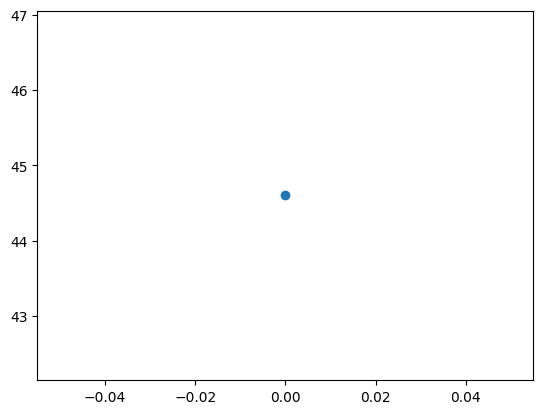

In [44]:
import matplotlib.pyplot as plt

plt.scatter(np.arange(len(equity_curve_arr)), equity_curve_arr)
for i in range(len(drawdowns)):
    if drawdowns[i] != 0:
        plt.plot(i, equity_curve_arr[i] - 10, marker='^', color='orange')
plt.show()

In [58]:
17547.4 / (60 * 60)

4.874277777777778

# BTC and ETH merging

In [100]:
df_btc = pd.read_csv(Path(r'C:/\Users/\vchar/\OneDrive/\Desktop/\ML Projects/\Upwork/\AlgoT_ML_Dev/\GrammarEvolution/\PonyGE2/\datasets/\BTC-1m.csv'))
# df_btc = pd.read_csv('/kaggle/input/btcusd-test/BTCUSD_ohlcv.csv')
df_btc['datetime'] = pd.to_datetime(df_btc['datetime'])
df_btc = df_btc.iloc[-10000:]
df_btc.sort_values('datetime', ascending=True, inplace=True)
df_btc.reset_index(inplace=True, drop=True)
df_btc.rename(
    columns={
        'open': 'btc_open', 
        'close': 'btc_close', 
        'low': 'btc_low', 
        'high': 'btc_high', 
        'volume': 'btc_volume'
    },
    inplace=True
)
df_btc.head()

,datetime,btc_open,btc_high,btc_low,btc_close,btc_volume
0,2024-09-04 17:50:00,58052.27,58055.91,57961.70,57975.48,6.286958
1,2024-09-04 17:51:00,57975.48,58014.30,57945.01,57948.03,13.541664
2,2024-09-04 17:52:00,57948.03,57948.03,57888.06,57892.97,11.412409
3,2024-09-04 17:53:00,57889.36,57898.18,57836.55,57857.49,6.163645
4,2024-09-04 17:54:00,57857.51,57915.60,57857.51,57912.29,8.040556


In [101]:
df_btc.tail()

,datetime,btc_open,btc_high,btc_low,btc_close,btc_volume
9995,2024-09-11 16:25:00,56864.38,56923.75,56847.32,56903.83,12.777984
9996,2024-09-11 16:26:00,56904.37,56916.37,56788.22,56808.40,10.192957
9997,2024-09-11 16:27:00,56804.54,56821.79,56787.89,56798.19,2.912109
9998,2024-09-11 16:28:00,56798.19,56831.83,56793.29,56830.72,3.706732
9999,2024-09-11 16:29:00,56828.08,56864.97,56828.08,56848.40,3.865301


In [102]:
df_eth = pd.read_csv(Path(r'C:/\Users/\vchar/\OneDrive/\Desktop/\ML Projects/\Upwork/\AlgoT_ML_Dev/\GrammarEvolution/\PonyGE2/\datasets/\ETH-1m.csv'))
# df_eth = pd.read_csv('/kaggle/input/btcusd-test/BTCUSD_ohlcv.csv')
df_eth['datetime'] = pd.to_datetime(df_eth['datetime'])
df_eth = df_eth.iloc[-10000:]
df_eth.sort_values('datetime', ascending=True, inplace=True)
df_eth.reset_index(inplace=True, drop=True)
df_eth.rename(
    columns={
        'open': 'eth_open', 
        'close': 'eth_close', 
        'low': 'eth_low', 
        'high': 'eth_high', 
        'volume': 'eth_volume'
    },
    inplace=True
)
df_eth.head()

,datetime,eth_open,eth_high,eth_low,eth_close,eth_volume
0,2024-09-07 14:22:00,2295.48,2295.48,2292.22,2292.22,8.133025
1,2024-09-07 14:23:00,2292.23,2293.17,2291.09,2292.84,18.279947
2,2024-09-07 14:24:00,2292.75,2293.33,2291.55,2292.98,12.682892
3,2024-09-07 14:25:00,2292.98,2293.07,2291.24,2292.00,29.546565
4,2024-09-07 14:26:00,2291.81,2294.84,2291.80,2294.80,7.415414


In [103]:
df_eth.tail()

,datetime,eth_open,eth_high,eth_low,eth_close,eth_volume
9995,2024-09-14 12:57:00,2421.30,2421.45,2420.28,2421.45,37.802834
9996,2024-09-14 12:58:00,2421.39,2421.44,2421.02,2421.24,3.580702
9997,2024-09-14 12:59:00,2421.24,2421.70,2421.12,2421.44,15.611558
9998,2024-09-14 13:00:00,2421.46,2421.52,2420.57,2421.40,10.753724
9999,2024-09-14 13:01:00,2421.26,2421.29,2420.61,2420.61,4.673591


In [104]:
df_sol = pd.read_csv(Path(r'C:/\Users/\vchar/\OneDrive/\Desktop/\ML Projects/\Upwork/\AlgoT_ML_Dev/\GrammarEvolution/\PonyGE2/\datasets/\SOL-1m.csv'))
# df_sol = pd.read_csv('/kaggle/input/btcusd-test/BTCUSD_ohlcv.csv')
df_sol['datetime'] = pd.to_datetime(df_sol['datetime'])
df_sol = df_sol.iloc[-10000:]
df_sol.sort_values('datetime', ascending=True, inplace=True)
df_sol.reset_index(inplace=True, drop=True)
df_sol.rename(
    columns={
        'open': 'sol_open', 
        'close': 'sol_close', 
        'low': 'sol_low', 
        'high': 'sol_high', 
        'volume': 'sol_volume'
    },
    inplace=True
)
df_sol.head()

,datetime,sol_open,sol_high,sol_low,sol_close,sol_volume
0,2023-11-22 12:01:00,54.50,54.52,54.47,54.51,475.244
1,2023-11-22 12:02:00,54.52,54.52,54.49,54.52,371.520
2,2023-11-22 12:03:00,54.50,54.63,54.50,54.63,538.134
3,2023-11-22 12:04:00,54.63,54.72,54.54,54.72,87.496
4,2023-11-22 12:05:00,54.72,54.72,54.70,54.70,4112.125


In [105]:
df_sol.tail()

,datetime,sol_open,sol_high,sol_low,sol_close,sol_volume
9995,2023-11-29 10:40:00,60.21,60.31,60.04,60.31,2471.730
9996,2023-11-29 10:41:00,60.32,60.32,60.22,60.26,417.767
9997,2023-11-29 10:42:00,60.28,60.30,60.22,60.30,541.638
9998,2023-11-29 10:43:00,60.32,60.45,60.29,60.33,1013.428
9999,2023-11-29 10:44:00,60.26,60.31,60.16,60.19,1979.268


In [106]:
# df_btc.set_index('datetime', inplace=True)
# df_eth.set_index('datetime', inplace=True)

df_m = pd.merge(df_btc, df_eth, on='datetime')
df_m.sort_values('datetime', ascending=True)
df_m.head()

,datetime,btc_open,btc_high,btc_low,btc_close,btc_volume,eth_open,eth_high,eth_low,eth_close,eth_volume
0,2024-09-07 14:22:00,54626.71,54626.71,54575.54,54587.68,3.029570,2295.48,2295.48,2292.22,2292.22,8.133025
1,2024-09-07 14:23:00,54579.67,54596.70,54557.25,54588.69,4.557107,2292.23,2293.17,2291.09,2292.84,18.279947
2,2024-09-07 14:24:00,54585.02,54605.49,54568.01,54605.49,3.003662,2292.75,2293.33,2291.55,2292.98,12.682892
3,2024-09-07 14:25:00,54605.49,54609.63,54581.65,54587.49,0.997784,2292.98,2293.07,2291.24,2292.00,29.546565
4,2024-09-07 14:26:00,54586.10,54658.16,54586.10,54658.16,2.026429,2291.81,2294.84,2291.80,2294.80,7.415414


In [107]:
df_m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5888 entries, 0 to 5887
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    5888 non-null   datetime64[ns]
 1   btc_open    5888 non-null   float64       
 2   btc_high    5888 non-null   float64       
 3   btc_low     5888 non-null   float64       
 4   btc_close   5888 non-null   float64       
 5   btc_volume  5888 non-null   float64       
 6   eth_open    5888 non-null   float64       
 7   eth_high    5888 non-null   float64       
 8   eth_low     5888 non-null   float64       
 9   eth_close   5888 non-null   float64       
 10  eth_volume  5888 non-null   float64       
dtypes: datetime64[ns](1), float64(10)
memory usage: 506.1 KB


In [108]:
df_m.to_csv(
    Path(r'C:/\Users/\vchar/\OneDrive/\Desktop/\ML Projects/\Upwork/\AlgoT_ML_Dev/\GrammarEvolution/\PonyGE2/\datasets/\BTC-ETH-1m.csv'),
    index=False
)

# Merging the data

In [16]:
main_path = Path(r'C:/\Users/\vchar/\Downloads/\FULL DATA LIBRARY')

files_list = os.listdir(main_path)
files_list

['6E_1m_databento_symbol_final_1min.csv',
 'AAPL_1m_databento.csv',
 'AAV-1m-1000wks-data.csv',
 'AMZN_1m_databento.csv',
 'BTC-1m-1000wks-data.csv',
 'CL_1m_databento_symbol_final_1min.csv',
 'COIN_1m_databento.csv',
 'DOG-1m-1000wks-data.csv',
 'ES_1m_databento_symbol_final_1min.csv',
 'ETH-1m-1000wks-data.csv_backup.csv',
 'FET-1m-1000wks-data.csv_backup.csv',
 'GC_1m_databento_symbol_final_1min.csv',
 'GOOGL_1m_databento.csv',
 'INJ-1m-1000wks-data.csv',
 'LIN-1m-1000wks-data.csv_backup.csv',
 'META_1m_databento.csv',
 'MSFT_1m_databento.csv',
 'NG_1m_databento_symbol_final_1min.csv',
 'NQ_1m_databento_symbol_final_1min.csv',
 'NVDA_1m_databento.csv',
 'PLTR_1m_databento.csv',
 'SOL-1m-1000wks-data.csv_backup.csv',
 'SUI-1m-1000wks-data.csv',
 'TIA-1m-1000wks-data.csv',
 'TSLA_1m_databento.csv',
 'XRP-1m-1000wks-data.csv',
 'ZF_1m_databento_symbol_final_1min.csv',
 'ZN_1m_databento_symbol_final_1min.csv']

In [47]:
# final_df = pd.DataFrame()

for i in range(len(files_list)):
    if i in [9, 21]:
        print(f"{files_list[i]} doesn't contain overlapping data.")
        continue
    temp_df = pd.read_csv(os.path.join(main_path, files_list[i]))
    instrument_name = files_list[i].replace('-', '_').split('_')[0].lower()
    temp_df['datetime'] = pd.to_datetime(temp_df['datetime'])
    temp_df.sort_values('datetime', ascending=True, inplace=True)
    # temp_df.set_index('datetime', inplace=True)
    temp_df.reset_index(inplace=True, drop=True)
    temp_df.rename(
        columns={
            'open': f'{instrument_name}_open', 
            'close': f'{instrument_name}_close', 
            'low': f'{instrument_name}_low', 
            'high': f'{instrument_name}_high', 
            'volume': f'{instrument_name}_volume'
        },
        inplace=True
    )
    # print(f"{i}: {files_list[i]}: start_date = {temp_df.iloc[0]['datetime']} end_date = {temp_df.iloc[-1]['datetime']}")
    if i == 0:
        final_df = temp_df.copy()
    else:
        final_df = pd.merge(final_df, temp_df, on='datetime')

    if final_df.shape[0] == 0:
        print(i)


ETH-1m-1000wks-data.csv_backup.csv doesn't contain overlapping data.
SOL-1m-1000wks-data.csv_backup.csv doesn't contain overlapping data.


In [48]:
final_df.head()

,datetime,6e_open,6e_high,6e_low,6e_close,6e_volume,aapl_open,aapl_high,aapl_low,aapl_close,...,zf_open,zf_high,zf_low,zf_close,zf_volume,zn_open,zn_high,zn_low,zn_close,zn_volume
0,2023-11-01 18:56:00,1.05600,1.05635,1.05590,1.05590,607,172.77,172.97,172.765,172.95,...,104.914062,104.945312,104.914062,104.937500,3727,106.812500,106.859375,106.796875,106.843750,11709
1,2023-11-01 18:58:00,1.05625,1.05640,1.05615,1.05630,396,173.10,173.27,173.060,173.25,...,104.937500,104.945312,104.921875,104.937500,3415,106.843750,106.859375,106.828125,106.859375,8757
2,2023-11-01 18:59:00,1.05630,1.05650,1.05605,1.05615,1569,173.24,173.24,173.090,173.19,...,104.937500,104.960938,104.929688,104.960938,13873,106.859375,106.875000,106.828125,106.875000,33414
3,2023-11-01 19:02:00,1.05650,1.05670,1.05640,1.05660,326,173.59,173.75,173.550,173.74,...,104.976562,105.015625,104.968750,105.007812,5523,106.906250,106.937500,106.890625,106.921875,7998
4,2023-11-01 19:03:00,1.05655,1.05675,1.05645,1.05665,327,173.72,173.73,173.650,173.72,...,105.000000,105.023438,105.000000,105.000000,4571,106.921875,106.953125,106.906250,106.906250,9335


In [49]:
final_df.tail()

,datetime,6e_open,6e_high,6e_low,6e_close,6e_volume,aapl_open,aapl_high,aapl_low,aapl_close,...,zf_open,zf_high,zf_low,zf_close,zf_volume,zn_open,zn_high,zn_low,zn_close,zn_volume
48886,2024-09-06 20:46:00,1.11335,1.11335,1.11335,1.11335,1,220.00,220.04,219.99,220.04,...,110.375000,110.375000,110.375000,110.375000,26,114.953125,114.968750,114.953125,114.953125,541
48887,2024-09-06 20:49:00,1.11335,1.11335,1.11330,1.11330,2,220.03,220.15,220.03,220.05,...,110.382812,110.398438,110.375000,110.390625,3449,114.968750,114.984375,114.968750,114.984375,3165
48888,2024-09-06 20:50:00,1.11330,1.11330,1.11330,1.11330,1,220.04,220.04,219.90,219.95,...,110.398438,110.406250,110.398438,110.406250,1568,114.984375,115.000000,114.984375,115.000000,2275
48889,2024-09-06 20:51:00,1.11335,1.11335,1.11335,1.11335,1,219.96,219.98,219.95,219.97,...,110.406250,110.406250,110.406250,110.406250,352,115.000000,115.015625,115.000000,115.000000,1493
48890,2024-09-06 20:54:00,1.11330,1.11330,1.11330,1.11330,2,219.95,219.95,219.75,219.86,...,110.421875,110.429688,110.421875,110.421875,66,115.015625,115.015625,115.000000,115.015625,2550


In [50]:
final_df.shape

(48891, 131)

In [53]:
np.unique([i.split('_')[0] for i in final_df.columns])

array(['6e', 'aapl', 'aav', 'amzn', 'btc', 'cl', 'coin', 'datetime',
       'dog', 'es', 'fet', 'gc', 'googl', 'inj', 'lin', 'meta', 'msft',
       'ng', 'nq', 'nvda', 'pltr', 'sui', 'tia', 'tsla', 'xrp', 'zf',
       'zn'], dtype='<U8')

In [54]:
final_df.to_csv("all_data_1min.csv", index=False)

In [ ]:
inst_list = [
    '6e', 'aapl', 'aav', 'amzn', 'btc', 'cl', 'coin',
    'dog', 'es', 'fet', 'gc', 'googl', 'inj', 'lin', 'meta', 'msft',
    'ng', 'nq', 'nvda', 'pltr', 'sui', 'tia', 'tsla', 'xrp', 'zf',
    'zn'
]

prefix_txt = '{:{:'
suffix_txt = ':}:}{::}'
it_txt = '_{i}'

for instrument in inst_list:

    if instrument == 'btc':
        continue

    text_template = f'''{prefix_txt}df[f"'"{instrument}_close{it_txt}"'"] = df["'"{instrument}_close"'"].shift(i){suffix_txt}
    {prefix_txt}df[f"'"{instrument}_open{it_txt}"'"] = df["'"{instrument}_open"'"].shift(i){suffix_txt}
    {prefix_txt}df[f"'"{instrument}_high{it_txt}"'"] = df["'"{instrument}_high"'"].shift(i){suffix_txt}
    {prefix_txt}df[f"'"{instrument}_low{it_txt}"'"] = df["'"{instrument}_low"'"].shift(i){suffix_txt}
    {prefix_txt}df[f"'"{instrument}_volume{it_txt}"'"] = df["'"{instrument}_volume"'"].shift(i){suffix_txt}'''

    print(text_template)

In [ ]:
inst_list = [
    '6e', 'aapl', 'aav', 'amzn', 'btc', 'cl', 'coin',
    'dog', 'es', 'fet', 'gc', 'googl', 'inj', 'lin', 'meta', 'msft',
    'ng', 'nq', 'nvda', 'pltr', 'sui', 'tia', 'tsla', 'xrp', 'zf',
    'zn'
]

for instrument in inst_list:

    if instrument == 'btc':
        continue

    txt_temp = f'''| df["'"{instrument}_close"'"].values.reshape(-1, 1) 
    | df["'"{instrument}_open"'"].values.reshape(-1, 1) 
    | df["'"{instrument}_high"'"].values.reshape(-1, 1) 
    | df["'"{instrument}_low"'"].values.reshape(-1, 1)
    | df["'"{instrument}_volume"'"].values.reshape(-1, 1)
    | df["'"{instrument}_close_1"'"].values.reshape(-1, 1) 
    | df["'"{instrument}_open_1"'"].values.reshape(-1, 1) 
    | df["'"{instrument}_high_1"'"].values.reshape(-1, 1) 
    | df["'"{instrument}_low_1"'"].values.reshape(-1, 1)
    | df["'"{instrument}_volume_1"'"].values.reshape(-1, 1)
    | df["'"{instrument}_close_2"'"].values.reshape(-1, 1) 
    | df["'"{instrument}_open_2"'"].values.reshape(-1, 1) 
    | df["'"{instrument}_high_2"'"].values.reshape(-1, 1) 
    | df["'"{instrument}_low_2"'"].values.reshape(-1, 1)
    | df["'"{instrument}_volume_2"'"].values.reshape(-1, 1)
    | df["'"{instrument}_close_3"'"].values.reshape(-1, 1) 
    | df["'"{instrument}_open_3"'"].values.reshape(-1, 1) 
    | df["'"{instrument}_high_3"'"].values.reshape(-1, 1) 
    | df["'"{instrument}_low_3"'"].values.reshape(-1, 1)
    | df["'"{instrument}_volume_3"'"].values.reshape(-1, 1)
    | df["'"{instrument}_close_4"'"].values.reshape(-1, 1) 
    | df["'"{instrument}_open_4"'"].values.reshape(-1, 1) 
    | df["'"{instrument}_high_4"'"].values.reshape(-1, 1) 
    | df["'"{instrument}_low_4"'"].values.reshape(-1, 1)
    | df["'"{instrument}_volume_4"'"].values.reshape(-1, 1)
    | df["'"{instrument}_close_5"'"].values.reshape(-1, 1) 
    | df["'"{instrument}_open_5"'"].values.reshape(-1, 1) 
    | df["'"{instrument}_high_5"'"].values.reshape(-1, 1) 
    | df["'"{instrument}_low_5"'"].values.reshape(-1, 1)
    | df["'"{instrument}_volume_5"'"].values.reshape(-1, 1)'''

    print(txt_temp)

# Extracting strategy from the code

In [11]:
import re 

text = '''def fun(price_data):
  import pandas as pd
  import numpy as np
  from fitness.indicators import indicators
  from numba import njit
  @njit
  def merge_pnl(arr1, arr2):
    out = np.zeros((len(arr1) + len(arr2)))
    idx = 1
    for i in range(len(arr1) + len(arr2)):
      if i % 2 == 0:
        out[i] = arr1[int(i/2)]
      else:
        out[i] = arr2[i-idx]
      idx += 1
    return out
  @njit
  def get_drawdowns(arr):
    drawdowns = np.zeros((len(arr)))
    max = arr[0]
    for i in range(1, len(drawdowns)-1):
      if arr[i-1] > arr[i] and arr[i] < arr[i+1]:
        min = arr[i]
        drawdowns[i] = max - min
      elif arr[i-1] < arr[i] and arr[i] > arr[i+1]:
        max = arr[i]
    return drawdowns
  df = price_data.copy()
  df['buy'] = (indicators.RSI(df=data, HistLength=10).values < 20).astype(int)
  df['sell'] = (indicators.RSI(df=data, HistLength=10).values > 80).astype(int)
  df['signal'] = df['buy'] + df['sell']
  df['signal'] = df['signal'].apply(lambda x: 1 if x==1 else 0)
  df['sell'] = df['sell'] * (-1)
  df['signal'] = df['signal'] * df['sell']
  df['signal'] = df['signal'] + df['buy']
  df.drop(columns=['buy', 'sell'], inplace=True)
  buy_idxs = []
  sell_idxs = []
  is_buy = 0
  is_sell = 0
  for i, row in enumerate(df.itertuples()):
    if row.signal == 1 and is_buy == 0:
      buy_idxs.append(i+1)
      is_buy = 1
      is_sell = 0
    elif row.signal == -1 and is_sell == 0:
      sell_idxs.append(i+1)
      is_sell = 1
      is_buy = 0
  if len(buy_idxs) > len(sell_idxs):
    buy_idxs = buy_idxs[:-(len(buy_idxs) - len(sell_idxs))]
  elif len(buy_idxs) < len(sell_idxs):
    sell_idxs = sell_idxs[:-(len(sell_idxs) - len(buy_idxs))]
  if len(buy_idxs) == 0 or len(sell_idxs) == 0:
    return 999
  buy_prices = df[df.index.isin(buy_idxs)]['open'].values
  sell_prices = df[df.index.isin(sell_idxs)]['open'].values
  if buy_idxs[0] < sell_idxs[0]:
    buy_pnl = np.sum(sell_prices - buy_prices)
    sell_pnl = np.sum(sell_prices[:-1] - buy_prices[1:])
    buy_arr = sell_prices - buy_prices
    sell_arr = sell_prices[:-1] - buy_prices[1:]
    all_arr = merge_pnl(buy_arr, sell_arr)
  else:
    sell_pnl = np.sum(sell_prices - buy_prices)
    buy_pnl = np.sum(sell_prices[1:] - buy_prices[:-1])
    sell_arr = sell_prices - buy_prices
    buy_arr = sell_prices[1:] - buy_prices[:-1]
    all_arr = merge_pnl(sell_arr, buy_arr)
  total_pnl = buy_pnl + sell_pnl
  equity_curve_arr = np.cumsum(all_arr)
  drawdowns = get_drawdowns(equity_curve_arr)
  avg_drawdown = np.sum(drawdowns[drawdowns!=0]) / len(drawdowns[drawdowns!=0])
  fitness = total_pnl / avg_drawdown
  if np.isnan(fitness):
    return 999
  return -fitness
fitness = fun(data)'''

re.findall(r"df\[\'buy\'\] = \((.*)\)\.astype\(int\)", text)

['indicators.RSI(df=data, HistLength=10).values < 20']

In [12]:
re.findall(r"df\[\'sell\'\] = \((.*)\)\.astype\(int\)", text)

['indicators.RSI(df=data, HistLength=10).values > 80']

In [ ]:
@njit(cache=True)
def get_pnl(
    trade_close_prices,
    trade_open_prices,
    commission=0.015,
    slippage=0.05,
    init_inv=20000,
    trade_size=0.1,
    is_buy=1
):

    pnl_list = np.zeros(len(trade_close_prices))

    for i in range(len(trade_close_prices)):
        
        temp_n_assets = int(init_inv * trade_size / trade_open_prices[i])
        if is_buy == 1:
            temp_pnl = temp_n_assets * (trade_close_prices[i] - trade_open_prices[i] * (1 + slippage))
        else:
            temp_pnl = -temp_n_assets * (trade_close_prices[i] - trade_open_prices[i] * (1 - slippage))
        temp_pnl = temp_pnl * (1 - commission)
        init_inv += temp_pnl

        pnl_list[i] = temp_pnl

    return pnl_list

In [31]:
def fun(price_data):
  import pandas as pd
  import numpy as np
  # from fitness.indicators import indicators
  from numba import njit
  COMMISSION = 0.015
  SLIPPAGE = 0.00005
  AVAILABLE_CAPITAL = 700000
  TRADE_SIZE = 0.5
  @njit
  def merge_pnl(arr1, arr2):
    out = np.zeros((len(arr1) + len(arr2)))
    idx = 1
    for i in range(len(arr1) + len(arr2)):
      if i % 2 == 0:
        out[i] = arr1[int(i/2)]
      else:
        out[i] = arr2[i-idx]
      idx += 1
    return out
  @njit
  def get_drawdowns(arr):
    drawdowns = np.zeros((len(arr)))
    max = arr[0]
    for i in range(1, len(drawdowns)-1):
      if arr[i-1] > arr[i] and arr[i] < arr[i+1]:
        min = arr[i]
        drawdowns[i] = max - min
      elif arr[i-1] < arr[i] and arr[i] > arr[i+1]:
        max = arr[i]
    return drawdowns
  @njit
  def get_pnl(trade_close_prices, trade_open_prices, commission, slippage, init_inv, trade_size, is_buy):
    pnl_list = np.zeros(len(trade_close_prices))
    for i in range(len(trade_close_prices)):
      temp_n_assets = int(init_inv * trade_size / trade_open_prices[i])
      if is_buy == 1:
        temp_pnl = temp_n_assets * (trade_close_prices[i] - trade_open_prices[i] * (1 + slippage))
      else:
        temp_pnl = -temp_n_assets * (trade_close_prices[i] - trade_open_prices[i] * (1 - slippage))
      temp_pnl = temp_pnl * (1 - commission)
      init_inv += temp_pnl
      pnl_list[i] = temp_pnl
    return pnl_list
  df = price_data.copy()
  for i in range(1, 6):
    df[f'close_{i}'] = df['close'].shift(i)
    df[f'open_{i}'] = df['open'].shift(i)
    df[f'high_{i}'] = df['high'].shift(i)
    df[f'low_{i}'] = df['low'].shift(i)
    df[f'volume_{i}'] = df['volume'].shift(i)
  df.dropna(inplace=True)
  df.reset_index(drop=True, inplace=True)
  df['buy'] = (RSI(df=df, HistLength=10).values < 20).astype(int)
  df['sell'] = (RSI(df=df, HistLength=10).values > 80).astype(int)
  df['signal'] = df['buy'] + df['sell']
  df['signal'] = df['signal'].apply(lambda x: 1 if x==1 else 0)
  df['sell'] = df['sell'] * (-1)
  df['signal'] = df['signal'] * df['sell']
  df['signal'] = df['signal'] + df['buy']
  df.drop(columns=['buy', 'sell'], inplace=True)
  buy_idxs = []
  sell_idxs = []
  is_buy = 0
  is_sell = 0
  for i, row in enumerate(df.itertuples()):
    if row.signal == 1 and is_buy == 0:
      buy_idxs.append(i+1)
      is_buy = 1
      is_sell = 0
    elif row.signal == -1 and is_sell == 0:
      sell_idxs.append(i+1)
      is_sell = 1
      is_buy = 0
  if len(buy_idxs) > len(sell_idxs):
    buy_idxs = buy_idxs[:-(len(buy_idxs) - len(sell_idxs))]
  elif len(buy_idxs) < len(sell_idxs):
    sell_idxs = sell_idxs[:-(len(sell_idxs) - len(buy_idxs))]
  if len(buy_idxs) == 0 or len(sell_idxs) == 0:
    return 999
  buy_prices = df[df.index.isin(buy_idxs)]['open'].values
  sell_prices = df[df.index.isin(sell_idxs)]['open'].values
  if buy_idxs[0] < sell_idxs[0]:
    buy_arr = get_pnl(sell_prices, buy_prices, COMMISSION, SLIPPAGE, AVAILABLE_CAPITAL, TRADE_SIZE, 1)
    buy_pnl = np.sum(buy_arr)
    sell_arr = get_pnl(buy_prices[1:], sell_prices[:-1], COMMISSION, SLIPPAGE, AVAILABLE_CAPITAL, TRADE_SIZE, 0)
    sell_pnl = np.sum(sell_arr)
    all_arr = merge_pnl(buy_arr, sell_arr)
  else:
    sell_arr = get_pnl(buy_prices, sell_prices, COMMISSION, SLIPPAGE, AVAILABLE_CAPITAL, TRADE_SIZE, 0)
    sell_pnl = np.sum(sell_arr)
    buy_arr = get_pnl(sell_prices[1:], buy_prices[:-1], COMMISSION, SLIPPAGE, AVAILABLE_CAPITAL, TRADE_SIZE, 1)
    buy_pnl = np.sum(buy_arr)
    all_arr = merge_pnl(sell_arr, buy_arr)
  total_pnl = buy_pnl + sell_pnl
  equity_curve_arr = np.cumsum(all_arr)
  drawdowns = get_drawdowns(equity_curve_arr)
  avg_drawdown = np.sum(drawdowns[drawdowns!=0]) / len(drawdowns[drawdowns!=0])
  fitness = total_pnl / avg_drawdown
  if np.isnan(fitness):
    return -999
  return -fitness
# fitness = fun(df)

# Limited testing

In [81]:
import pandas as pd
import numpy as np
from src.fitness.indicators import indicators
from numba import njit
COMMISSION = 0.015
SLIPPAGE = 0.00005
AVAILABLE_CAPITAL = 700000
TRADE_SIZE = 0.5

@njit
def merge_pnl(arr1, arr2):
    out = np.zeros((len(arr1) + len(arr2)))
    idx = 1
    for i in range(len(arr1) + len(arr2)):
        if i % 2 == 0:
            out[i] = arr1[int(i/2)]
        else:
            out[i] = arr2[i-idx]
        idx += 1
    return out

@njit
def get_drawdowns(arr):
    drawdowns = np.zeros((len(arr)))
    max = arr[0]
    for i in range(1, len(drawdowns)-1):
        if arr[i-1] > arr[i] and arr[i] < arr[i+1]:
            min = arr[i]
            drawdowns[i] = max - min
        elif arr[i-1] < arr[i] and arr[i] > arr[i+1]:
            max = arr[i]
    return drawdowns

@njit
def get_pnl(trade_close_prices, trade_open_prices, commission, slippage, init_inv, trade_size, is_buy):
    pnl_list = np.zeros(len(trade_close_prices))
    for i in range(len(trade_close_prices)):
        temp_n_assets = int(init_inv * trade_size / trade_open_prices[i])
        if is_buy == 1:
            temp_pnl = temp_n_assets * (trade_close_prices[i] - trade_open_prices[i] * (1 + slippage))
        else:
            temp_pnl = -temp_n_assets * (trade_close_prices[i] - trade_open_prices[i] * (1 - slippage))
        temp_pnl = temp_pnl * (1 - commission)
        init_inv += temp_pnl
        pnl_list[i] = temp_pnl
    return pnl_list

# df = price_data.copy()
# for i in range(1, 6):
#     df[f'close_{i}'] = df['close'].shift(i)
#     df[f'open_{i}'] = df['open'].shift(i)
#     df[f'high_{i}'] = df['high'].shift(i)
#     df[f'low_{i}'] = df['low'].shift(i)
#     df[f'volume_{i}'] = df['volume'].shift(i)
# df.dropna(inplace=True)
# df.reset_index(drop=True, inplace=True)

df['buy'] = (indicators.RSI(df=df, HistLength=10).values < 20).astype(int)
df['sell'] = (indicators.RSI(df=df, HistLength=10).values > 80).astype(int)
df['signal'] = df['buy'] + df['sell']
df['signal'] = df['signal'].apply(lambda x: 1 if x==1 else 0)
df['sell'] = df['sell'] * (-1)
df['signal'] = df['signal'] * df['sell']
df['signal'] = df['signal'] + df['buy']
df.drop(columns=['buy', 'sell'], inplace=True)

buy_idxs = []
sell_idxs = []
is_buy = 0
is_sell = 0
for i, row in enumerate(df.itertuples()):
    if row.signal == 1 and is_buy == 0:
        buy_idxs.append(i+1)
        is_buy = 1
        is_sell = 0
    elif row.signal == -1 and is_sell == 0:
        sell_idxs.append(i+1)
        is_sell = 1
        is_buy = 0

if len(buy_idxs) > len(sell_idxs):
    buy_idxs = buy_idxs[:-(len(buy_idxs) - len(sell_idxs))]
elif len(buy_idxs) < len(sell_idxs):
    sell_idxs = sell_idxs[:-(len(sell_idxs) - len(buy_idxs))]

if len(buy_idxs) == 0 or len(sell_idxs) == 0:
    print("not enough signals")

buy_prices = df[df.index.isin(buy_idxs)]['open'].values
sell_prices = df[df.index.isin(sell_idxs)]['open'].values

if buy_idxs[0] < sell_idxs[0]:
    buy_arr = get_pnl(sell_prices, buy_prices, COMMISSION, SLIPPAGE, AVAILABLE_CAPITAL, TRADE_SIZE, 1)
    buy_pnl = np.sum(buy_arr)
    sell_arr = get_pnl(buy_prices[1:], sell_prices[:-1], COMMISSION, SLIPPAGE, AVAILABLE_CAPITAL, TRADE_SIZE, 0)
    sell_pnl = np.sum(sell_arr)
    all_arr = merge_pnl(buy_arr, sell_arr)
else:
    sell_arr = get_pnl(buy_prices, sell_prices, COMMISSION, SLIPPAGE, AVAILABLE_CAPITAL, TRADE_SIZE, 0)
    sell_pnl = np.sum(sell_arr)
    buy_arr = get_pnl(sell_prices[1:], buy_prices[:-1], COMMISSION, SLIPPAGE, AVAILABLE_CAPITAL, TRADE_SIZE, 1)
    buy_pnl = np.sum(buy_arr)
    all_arr = merge_pnl(sell_arr, buy_arr)

total_pnl = buy_pnl + sell_pnl
equity_curve_arr = np.cumsum(all_arr)
drawdowns = get_drawdowns(equity_curve_arr)
avg_drawdown = np.sum(drawdowns[drawdowns!=0]) / len(drawdowns[drawdowns!=0])
fitness = total_pnl / avg_drawdown

In [82]:
print(buy_idxs)

[95, 396, 525, 609, 695, 732, 918, 1088, 1228, 1439, 1566, 1801, 1890, 2061, 2272, 2433, 2521, 2833, 2882, 2970, 3097, 3473, 3764, 3836, 4088, 4427, 4583, 4804, 4939, 5012, 5173, 5220, 5534, 5850, 5965, 6254, 6598, 6674, 6807, 7125, 7336, 7440, 7521, 7584, 7781, 7910, 8080, 8191, 8462, 8622, 8753, 8948, 9091, 9375, 9488]


In [83]:
print(sell_idxs)

[15, 373, 496, 574, 651, 711, 801, 972, 1107, 1376, 1526, 1747, 1870, 1993, 2198, 2294, 2481, 2579, 2860, 2948, 3024, 3242, 3510, 3782, 3990, 4205, 4549, 4720, 4831, 4985, 5061, 5209, 5301, 5701, 5893, 6023, 6311, 6630, 6758, 6931, 7318, 7413, 7488, 7566, 7650, 7876, 8012, 8094, 8297, 8496, 8730, 8865, 9012, 9281, 9433]


In [11]:
len(buy_idxs), len(sell_idxs)

(55, 55)

In [12]:
signal_idxs = buy_idxs.copy()
signal_idxs.extend(sell_idxs)
signal_idxs = sorted(signal_idxs)
print(signal_idxs)

[15, 95, 373, 396, 496, 525, 574, 609, 651, 695, 711, 732, 801, 918, 972, 1088, 1107, 1228, 1376, 1439, 1526, 1566, 1747, 1801, 1870, 1890, 1993, 2061, 2198, 2272, 2294, 2433, 2481, 2521, 2579, 2833, 2860, 2882, 2948, 2970, 3024, 3097, 3242, 3473, 3510, 3764, 3782, 3836, 3990, 4088, 4205, 4427, 4549, 4583, 4720, 4804, 4831, 4939, 4985, 5012, 5061, 5173, 5209, 5220, 5301, 5534, 5701, 5850, 5893, 5965, 6023, 6254, 6311, 6598, 6630, 6674, 6758, 6807, 6931, 7125, 7318, 7336, 7413, 7440, 7488, 7521, 7566, 7584, 7650, 7781, 7876, 7910, 8012, 8080, 8094, 8191, 8297, 8462, 8496, 8622, 8730, 8753, 8865, 8948, 9012, 9091, 9281, 9375, 9433, 9488]


In [13]:
signal_idxs_true = [i - 1 for i in signal_idxs]
print(signal_idxs_true)

[14, 94, 372, 395, 495, 524, 573, 608, 650, 694, 710, 731, 800, 917, 971, 1087, 1106, 1227, 1375, 1438, 1525, 1565, 1746, 1800, 1869, 1889, 1992, 2060, 2197, 2271, 2293, 2432, 2480, 2520, 2578, 2832, 2859, 2881, 2947, 2969, 3023, 3096, 3241, 3472, 3509, 3763, 3781, 3835, 3989, 4087, 4204, 4426, 4548, 4582, 4719, 4803, 4830, 4938, 4984, 5011, 5060, 5172, 5208, 5219, 5300, 5533, 5700, 5849, 5892, 5964, 6022, 6253, 6310, 6597, 6629, 6673, 6757, 6806, 6930, 7124, 7317, 7335, 7412, 7439, 7487, 7520, 7565, 7583, 7649, 7780, 7875, 7909, 8011, 8079, 8093, 8190, 8296, 8461, 8495, 8621, 8729, 8752, 8864, 8947, 9011, 9090, 9280, 9374, 9432, 9487]


In [14]:
len(signal_idxs)

110

In [15]:
df['new_signal'] = 0
df.loc[df.index.isin(signal_idxs_true), 'new_signal'] = df.loc[df.index.isin(signal_idxs_true), 'signal'].values
# df.loc[~df.index.isin(signal_idxs), 'new_signal'] = 0

In [16]:
df[df['new_signal']==-1].shape

(55, 8)

In [17]:
df.loc[df.index.isin(signal_idxs_true), 'signal'].values

array([-1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,
        1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1,
       -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,
        1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1,
       -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,
        1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1,
       -1,  1, -1,  1, -1,  1, -1,  1], dtype=int64)

In [18]:
df['signal_prices'] = 0
df.loc[df.index.isin(signal_idxs), 'signal_prices'] = df.loc[df.index.isin(signal_idxs), 'open'].values

In [19]:
df.loc[df.index.isin(signal_idxs), 'open'].values

array([16550. , 16569.6, 16568.5, 16554.5, 16536.9, 16532.7, 16543.3,
       16531.5, 16539.6, 16550.4, 16563.7, 16543.6, 16541.3, 16558.2,
       16561.6, 16570.8, 16599.9, 16569.1, 16568.7, 16548.6, 16548.2,
       16458.4, 16531.8, 16526.2, 16518.8, 16507.5, 16517.5, 16513.5,
       16496.3, 16515. , 16524.5, 16530.1, 16527.9, 16529.6, 16527.9,
       16578.7, 16604.1, 16589. , 16587.5, 16580.3, 16589.1, 16583.1,
       16564.4, 16630.3, 16685.1, 16706. , 16726.4, 16725.5, 16699.3,
       16713.8, 16711.6, 16698.5, 16691.5, 16665.2, 16679.5, 16671.6,
       16689.8, 16709.7, 16717.2, 16703.6, 16715.1, 16714.4, 16717.4,
       16703. , 16716.4, 16606.1, 16640. , 16640.1, 16664.4, 16650.4,
       16659.1, 16847.6, 16842.2, 16827. , 16842.5, 16828. , 16829. ,
       16803.7, 16873.6, 16791.5, 16826. , 16803.6, 16862.2, 16836.1,
       16834.1, 16812.5, 16829.1, 16816.5, 16819.6, 16821.1, 16812. ,
       16797. , 16809.9, 16807. , 16816.3, 16799.1, 16820. , 16801.8,
       16812. , 1682

In [20]:
signal_list = np.zeros((2, df.shape[0]))
signal_list[0][1:] = df['new_signal'].values[:-1]
signal_list[1] = df['signal_prices'].values

In [21]:
print([i for i in range(len(signal_list[0])) if signal_list[0][i] != 0])

[15, 95, 373, 396, 496, 525, 574, 609, 651, 695, 711, 732, 801, 918, 972, 1088, 1107, 1228, 1376, 1439, 1526, 1566, 1747, 1801, 1870, 1890, 1993, 2061, 2198, 2272, 2294, 2433, 2481, 2521, 2579, 2833, 2860, 2882, 2948, 2970, 3024, 3097, 3242, 3473, 3510, 3764, 3782, 3836, 3990, 4088, 4205, 4427, 4549, 4583, 4720, 4804, 4831, 4939, 4985, 5012, 5061, 5173, 5209, 5220, 5301, 5534, 5701, 5850, 5893, 5965, 6023, 6254, 6311, 6598, 6630, 6674, 6758, 6807, 6931, 7125, 7318, 7336, 7413, 7440, 7488, 7521, 7566, 7584, 7650, 7781, 7876, 7910, 8012, 8080, 8094, 8191, 8297, 8462, 8496, 8622, 8730, 8753, 8865, 8948, 9012, 9091, 9281, 9375, 9433, 9488]


In [22]:
print(signal_idxs)

[15, 95, 373, 396, 496, 525, 574, 609, 651, 695, 711, 732, 801, 918, 972, 1088, 1107, 1228, 1376, 1439, 1526, 1566, 1747, 1801, 1870, 1890, 1993, 2061, 2198, 2272, 2294, 2433, 2481, 2521, 2579, 2833, 2860, 2882, 2948, 2970, 3024, 3097, 3242, 3473, 3510, 3764, 3782, 3836, 3990, 4088, 4205, 4427, 4549, 4583, 4720, 4804, 4831, 4939, 4985, 5012, 5061, 5173, 5209, 5220, 5301, 5534, 5701, 5850, 5893, 5965, 6023, 6254, 6311, 6598, 6630, 6674, 6758, 6807, 6931, 7125, 7318, 7336, 7413, 7440, 7488, 7521, 7566, 7584, 7650, 7781, 7876, 7910, 8012, 8080, 8094, 8191, 8297, 8462, 8496, 8622, 8730, 8753, 8865, 8948, 9012, 9091, 9281, 9375, 9433, 9488]


## Entry testing

### Fixed stop and target exit

In [23]:
@njit(cache=True)
def get_exit_entry_testing1(
    close_prices, 
    open_prices,  
    signal_list,
    stoploss_th,
    takeprofit_th, 
    commission, 
    slippage, 
    init_inv, 
    trade_size
):

    exit_list = np.zeros((2, len(close_prices)))

    for i in range(len(close_prices)-1):

        if signal_list[1][i] == 0:

            pass

        else:

            temp_n_assets = int(init_inv * trade_size / signal_list[1][i])
            if signal_list[0][i] == 1:
                temp_pnl = temp_n_assets * (close_prices[i] - signal_list[1][i] * (1 + slippage))
            else:
                temp_pnl = -temp_n_assets * (close_prices[i] - signal_list[1][i] * (1 - slippage))
            temp_pnl = temp_pnl * (1 - commission)
            init_inv += temp_pnl

            if -temp_pnl >= stoploss_th or temp_pnl >= takeprofit_th:
                exit_list[0][i+1] = -signal_list[0][i]
                exit_list[1][i+1] = open_prices[i+1]
            else:
                pass
        
    return exit_list

In [24]:
exit_list = get_exit_entry_testing1(
    close_prices=df['close'].values, 
    open_prices=df['open'].values,  
    signal_list=signal_list,
    stoploss_th=50,
    takeprofit_th=100,
    commission=COMMISSION, 
    slippage=SLIPPAGE, 
    init_inv=AVAILABLE_CAPITAL, 
    trade_size=TRADE_SIZE
)

In [25]:
sum(exit_list[0]), sum(exit_list[1])

(8.0, 567961.2)

In [26]:
np.sum(np.where(exit_list[0]!=0, 1, 0)), np.sum(np.where(exit_list[1]!=0, 1, 0))

(34, 34)

In [27]:
exit_list[1][exit_list[1]!=0]

array([16579. , 16538.8, 16569.5, 16562.8, 16562. , 16550. , 16490.6,
       16526.3, 16585.7, 16587.5, 16628.7, 16721.4, 16713.5, 16710.3,
       16716.5, 16685.4, 16633.6, 16636.5, 16668.5, 16844.7, 16844.9,
       16801. , 16862.8, 16828.4, 16812.1, 16831.4, 16794.6, 16812.6,
       16838.9, 16816. , 16827.3, 16819.9, 16798.8, 16761.2])

In [28]:
@njit(cache=True)
def get_signals(signal_list, exit_list):

    start_idx = 0
    exit_idx = 0
   
    for i in range(len(signal_list[0])):

        if i == start_idx:

            if signal_list[0][i] == 0:

                start_idx += 1

                exit_list[0][i] = 0

            else:

                for j in range(i+1, len(exit_list[0])):
                    if exit_list[0][j] == -signal_list[0][i]:
                        exit_idx = j
                        break
                    else:
                        exit_idx = j

                for k in range(i+1, exit_idx+1):
                    if signal_list[0][k] == -signal_list[0][i]:
                        exit_idx = k
                        exit_list[1][k] = signal_list[1][k]
                        break
                    else:
                        exit_idx = k

                for p in range(i+1, exit_idx):
                    signal_list[0][p] = 0
                    exit_list[0][p] = 0
                
                if exit_idx == len(signal_list[0]) - 1 and exit_list[0][exit_idx] != -signal_list[0][i]:
                    exit_list[0][exit_idx] = 0
                    exit_list[0][i] = 0
                    signal_list[0][exit_idx] = 0
                else:
                    exit_list[0][exit_idx] = -signal_list[0][i]
                    exit_list[0][i] = 0
                    signal_list[0][exit_idx] = 0
                
                start_idx = exit_idx + 1

        else:

            continue

    if sum(np.abs(signal_list[0])) == sum(np.abs(exit_list[0])):

        return signal_list, exit_list
    
    else:

        for i in range(len(signal_list[0])):
            if signal_list[0][-(i+1)] != 0:
                signal_list[0][-(i+1)] = 0
                break

        return signal_list, exit_list
    
@njit(cache=True)
def create_position_open_prices(signal_list, exit_list):

    pos_open_prices = np.zeros(len(signal_list[0]))
    pos_exit_prices = np.zeros(len(exit_list[0]))

    start_idx = 0
    price_idx = 0

    for i in range(len(signal_list[0])):
        if exit_list[0][i] != 0:
            for j in range(start_idx, i):
                if signal_list[0][j] != 0:
                    price_idx = j
                    break
            pos_open_prices[i] = signal_list[1][price_idx]
            pos_exit_prices[i] = exit_list[1][i]
            start_idx = i
        else:
            pass

    return pos_open_prices, pos_exit_prices

In [95]:
@njit(cache=True)
def get_pnl_testing(
    trade_close_prices,
    signal_list, 
    trade_open_prices,
    commission=0.015,
    slippage=0.05,
    init_inv=20000,
    trade_size=0.1
):

    pnl_list = np.zeros(len(trade_close_prices))

    for i in range(len(trade_close_prices)):

        if signal_list[i] == 0 or trade_open_prices[i] == 0:
            pass
        
        # signal_list contains the points where exit occurs
        elif signal_list[i] == -1: 
            temp_n_assets = int(init_inv * trade_size / trade_open_prices[i])
            temp_pnl = temp_n_assets * (trade_close_prices[i] - trade_open_prices[i] * (1 + slippage)) 
            temp_pnl = temp_pnl * (1 - commission)
            init_inv += temp_pnl

        else:
            temp_n_assets = int(init_inv * trade_size / trade_open_prices[i])
            temp_pnl = temp_n_assets * (trade_open_prices[i] * (1 - slippage) - trade_close_prices[i])
            temp_pnl = temp_pnl * (1 - commission)
            init_inv += temp_pnl

        pnl_list[i] = temp_pnl

    return pnl_list

In [30]:
signal_list, exit_list = get_signals(signal_list, exit_list)
pos_open_prices, pos_exit_prices = create_position_open_prices(signal_list, exit_list)

pnl_list = get_pnl_testing(
    trade_close_prices=pos_exit_prices,
    signal_list=exit_list[0], 
    trade_open_prices=pos_open_prices,
    commission=COMMISSION, 
    slippage=SLIPPAGE, 
    init_inv=AVAILABLE_CAPITAL, 
    trade_size=TRADE_SIZE
)

winning_percent = 100 * sum(pnl_list > 0) / len(pnl_list)
winning_percent

57.410714285714285

In [31]:
winning_percent = 100 * sum(pnl_list > 0) / np.sum(np.where(pnl_list!=0, 1, 0))
winning_percent

57.501987281399046

In [32]:
np.sum(np.where(pnl_list!=0, 1, 0))

10064

### Fixed bar exit

In [34]:
@njit(cache=True)
def get_exit_entry_testing2( 
    open_prices,  
    signal_list,
    n_exit_bars
):

    exit_list = np.zeros((2, len(signal_list[0])))

    n_exit_bars = np.int64(n_exit_bars)

    for i in range(len(signal_list[0])-1):

        if signal_list[0][i] == 0:

            pass

        else:
            
            if i + n_exit_bars < len(signal_list[0]):
                exit_list[0][i+n_exit_bars] = -signal_list[0][i]
                exit_list[1][i+n_exit_bars] = open_prices[i+n_exit_bars]
            else:
                pass
        
    return exit_list

In [35]:
exit_list = get_exit_entry_testing2( 
    open_prices=df['open'].values,  
    signal_list=signal_list,
    n_exit_bars=5
)

In [36]:
sum(exit_list[0]), sum(exit_list[1])

(-16.0, 1067607.2)

In [37]:
np.sum(np.where(exit_list[0]!=0, 1, 0)), np.sum(np.where(exit_list[1]!=0, 1, 0))

(64, 64)

In [38]:
signal_list, exit_list = get_signals(signal_list, exit_list)
pos_open_prices, pos_exit_prices = create_position_open_prices(signal_list, exit_list)

pnl_list = get_pnl_testing(
    trade_close_prices=pos_exit_prices,
    signal_list=exit_list[0], 
    trade_open_prices=pos_open_prices,
    commission=COMMISSION, 
    slippage=SLIPPAGE, 
    init_inv=AVAILABLE_CAPITAL, 
    trade_size=TRADE_SIZE
)

winning_percent = 100 * sum(pnl_list > 0) / len(pnl_list)
winning_percent

36.97420634920635

In [39]:
winning_percent = 100 * sum(pnl_list > 0) / np.sum(np.where(pnl_list!=0, 1, 0))
winning_percent

37.04771371769384

### Random exit

In [47]:
@njit(cache=True)
def get_exit_entry_testing3( 
    open_prices,  
    signal_list
):

    exit_list = np.zeros((2, len(signal_list[0])))

    for i in range(len(signal_list[0])-1):

        if signal_list[0][i] == 0:

            pass

        else:

            for j in range(i+1, len(signal_list[0])):
                if signal_list[0][j] != 0:
                    j = j - 1
                    break
                else:
                    if np.random.rand() > 0.5:
                        break
            
            exit_list[0][j] = -signal_list[0][i]
            exit_list[1][j] = open_prices[j]
        
    return exit_list

In [48]:
exit_list = get_exit_entry_testing3( 
    open_prices=df['open'].values,  
    signal_list=signal_list
)

In [49]:
sum(exit_list[0]), sum(exit_list[1])

(-16.0, 1067603.0)

In [50]:
np.sum(np.where(exit_list[0]!=0, 1, 0)), np.sum(np.where(exit_list[1]!=0, 1, 0))

(64, 64)

In [51]:
signal_list, exit_list = get_signals(signal_list, exit_list)
pos_open_prices, pos_exit_prices = create_position_open_prices(signal_list, exit_list)

pnl_list = get_pnl_testing(
    trade_close_prices=pos_exit_prices,
    signal_list=exit_list[0], 
    trade_open_prices=pos_open_prices,
    commission=COMMISSION, 
    slippage=SLIPPAGE, 
    init_inv=AVAILABLE_CAPITAL, 
    trade_size=TRADE_SIZE
)

winning_percent = 100 * sum(pnl_list > 0) / len(pnl_list)
winning_percent

27.172619047619047

In [52]:
winning_percent = 100 * sum(pnl_list > 0) / np.sum(np.where(pnl_list!=0, 1, 0))
winning_percent

27.218523303189905

## Exit testing

In [53]:
df['exit_signal'] = 0
df.loc[df.index.isin(signal_idxs_true[1:]), 'exit_signal'] = df.loc[df.index.isin(signal_idxs_true[1:]), 'signal'].values

df['exit_prices'] = 0
df.loc[df.index.isin(signal_idxs[1:]), 'exit_prices'] = df.loc[df.index.isin(signal_idxs[1:]), 'open'].values

exit_list = np.zeros((2, df.shape[0]))
exit_list[0][1:] = df['exit_signal'].values[:-1]
exit_list[1] = df['exit_prices'].values

In [54]:
print([i for i in range(len(exit_list[0])) if exit_list[0][i] != 0])

[95, 373, 396, 496, 525, 574, 609, 651, 695, 711, 732, 801, 918, 972, 1088, 1107, 1228, 1376, 1439, 1526, 1566, 1747, 1801, 1870, 1890, 1993, 2061, 2198, 2272, 2294, 2433, 2481, 2521, 2579, 2833, 2860, 2882, 2948, 2970, 3024, 3097, 3242, 3473, 3510, 3764, 3782, 3836, 3990, 4088, 4205, 4427, 4549, 4583, 4720, 4804, 4831, 4939, 4985, 5012, 5061, 5173, 5209, 5220, 5301, 5534, 5701, 5850, 5893, 5965, 6023, 6254, 6311, 6598, 6630, 6674, 6758, 6807, 6931, 7125, 7318, 7336, 7413, 7440, 7488, 7521, 7566, 7584, 7650, 7781, 7876, 7910, 8012, 8080, 8094, 8191, 8297, 8462, 8496, 8622, 8730, 8753, 8865, 8948, 9012, 9091, 9281, 9375, 9433, 9488]


In [55]:
print(signal_idxs[1:])

[95, 373, 396, 496, 525, 574, 609, 651, 695, 711, 732, 801, 918, 972, 1088, 1107, 1228, 1376, 1439, 1526, 1566, 1747, 1801, 1870, 1890, 1993, 2061, 2198, 2272, 2294, 2433, 2481, 2521, 2579, 2833, 2860, 2882, 2948, 2970, 3024, 3097, 3242, 3473, 3510, 3764, 3782, 3836, 3990, 4088, 4205, 4427, 4549, 4583, 4720, 4804, 4831, 4939, 4985, 5012, 5061, 5173, 5209, 5220, 5301, 5534, 5701, 5850, 5893, 5965, 6023, 6254, 6311, 6598, 6630, 6674, 6758, 6807, 6931, 7125, 7318, 7336, 7413, 7440, 7488, 7521, 7566, 7584, 7650, 7781, 7876, 7910, 8012, 8080, 8094, 8191, 8297, 8462, 8496, 8622, 8730, 8753, 8865, 8948, 9012, 9091, 9281, 9375, 9433, 9488]


### Similar approach entry

In [58]:
@njit(cache=True)
def get_entry_exit_testing1(
    close_prices,
    open_prices,
    n_bars
):

    signal_list = np.zeros((2, len(close_prices)))

    # n_bars = np.int64(n_bars)

    for i in range(n_bars, len(signal_list[0])):
            
        if close_prices[i - n_bars] - close_prices[i - 1] > 0:
            signal_list[0][i] = 1
            signal_list[1][i] = open_prices[i]
        elif close_prices[i - n_bars] - close_prices[i - 1] < 0:
           signal_list[0][i] = -1
           signal_list[1][i] = open_prices[i]
        else:
            pass
        
    return signal_list

In [59]:
signal_list = get_entry_exit_testing1(
    close_prices=df['close'].values,
    open_prices=df['open'].values,
    n_bars=5
)

In [60]:
sum(signal_list[0]), sum(signal_list[1])

(72.0, 161171668.60000023)

In [61]:
np.sum(np.where(signal_list[0]!=0, 1, 0)), np.sum(np.where(signal_list[1]!=0, 1, 0))

(9654, 9654)

In [62]:
signal_list, exit_list = get_signals(signal_list, exit_list)
pos_open_prices, pos_exit_prices = create_position_open_prices(signal_list, exit_list)

pnl_list = get_pnl_testing(
    trade_close_prices=pos_exit_prices,
    signal_list=exit_list[0], 
    trade_open_prices=pos_open_prices,
    commission=COMMISSION, 
    slippage=SLIPPAGE, 
    init_inv=AVAILABLE_CAPITAL, 
    trade_size=TRADE_SIZE
)

winning_percent = 100 * sum(pnl_list > 0) / len(pnl_list)
winning_percent

47.291666666666664

In [63]:
winning_percent = 100 * sum(pnl_list > 0) / np.sum(np.where(pnl_list!=0, 1, 0))
winning_percent

47.3198332340679

In [65]:
@njit(cache=True)
def get_rsi(close_prices, prev_close_prices, length=14):
    # Create numpy arrays to store the gain/loss values
    gains = np.zeros(len(close_prices))
    losses = np.zeros(len(close_prices))

    # Iterate through the data frame and calculate the gain/loss for each period
    for i in range(1, len(close_prices)):
        change = close_prices[i] - prev_close_prices[i]
        if change > 0:
            gains[i] = change
        elif change < 0:
            losses[i] = abs(change)

    # Calculate the average gain and loss for each period
    avg_gains = np.zeros(len(close_prices))
    avg_losses = np.zeros(len(close_prices))
    for i in range(length, len(close_prices)):
        avg_gains[i] = np.mean(gains[i-length:i])
        avg_losses[i] = np.mean(losses[i-length:i])

    # Calculate the relative strength and RSI for each period
    rs = np.zeros(len(close_prices))
    rsi = np.zeros(len(close_prices))
    
    for i in range(len(close_prices)):
        if i+1 < length:
            rsi[i] = -999
        elif avg_losses[i] == 0:
            rs[i] = avg_gains[i]
            rsi[i] = 100
        else:
            rs[i] = avg_gains[i] / avg_losses[i]
            rsi[i] = 100 - (100 / (1 + rs[i]))

    return rsi

In [66]:
@njit(cache=True)
def get_entry_exit_testing2(
    close_prices, open_prices, prev_close_prices, rsi_window_size, rsi_threshold
):

    signal_list = np.zeros((2, len(close_prices)))

    rsi = get_rsi(close_prices, prev_close_prices, length=rsi_window_size)

    for i in range(len(close_prices)-1):

        if i < rsi_window_size - 1 or rsi[i] == -999:
            continue
       
        if rsi[i] < rsi_threshold:
            signal_list[0][i+1] = 1
            signal_list[1][i+1] = open_prices[i+1]
        elif rsi[i] > (100 - rsi_threshold):
            signal_list[0][i+1] = -1
            signal_list[1][i+1] = open_prices[i+1]
        else:
            pass

    return signal_list

In [67]:
signal_list = get_entry_exit_testing2(
    close_prices=df['close'].values, 
    open_prices=df['open'].values, 
    prev_close_prices=df['close'].shift(1).fillna(method='bfill').values, 
    rsi_window_size=10, 
    rsi_threshold = 20
)

In [68]:
sum(signal_list[0]), sum(signal_list[1])

(34.0, 54070094.599999815)

In [69]:
np.sum(np.where(signal_list[0]!=0, 1, 0)), np.sum(np.where(signal_list[1]!=0, 1, 0))

(3242, 3242)

In [70]:
signal_list, exit_list = get_signals(signal_list, exit_list)
pos_open_prices, pos_exit_prices = create_position_open_prices(signal_list, exit_list)

pnl_list = get_pnl_testing(
    trade_close_prices=pos_exit_prices,
    signal_list=exit_list[0], 
    trade_open_prices=pos_open_prices,
    commission=COMMISSION, 
    slippage=SLIPPAGE, 
    init_inv=AVAILABLE_CAPITAL, 
    trade_size=TRADE_SIZE
)

winning_percent = 100 * sum(pnl_list > 0) / len(pnl_list)
winning_percent

50.198412698412696

In [71]:
winning_percent = 100 * sum(pnl_list > 0) / np.sum(np.where(pnl_list!=0, 1, 0))
winning_percent

50.30321105477682

In [72]:
@njit(cache=True)
def get_entry_exit_testing3(
    open_prices
):

    signal_list = np.zeros((2, len(open_prices)))

    for i in range(len(open_prices)-1):

        if np.random.rand() > 0.7:
            signal_list[0][i] = 1
            signal_list[1][i] = open_prices[i]
        elif np.random.rand() < 0.3:
            signal_list[0][i] = -1
            signal_list[1][i] = open_prices[i]
        else:
            pass

    return signal_list

In [73]:
signal_list = get_entry_exit_testing3(
    open_prices=df['open'].values
)

In [74]:
sum(signal_list[0]), sum(signal_list[1])

(877.0, 85355821.69999993)

In [75]:
np.sum(np.where(signal_list[0]!=0, 1, 0)), np.sum(np.where(signal_list[1]!=0, 1, 0))

(5113, 5113)

In [76]:
signal_list, exit_list = get_signals(signal_list, exit_list)
pos_open_prices, pos_exit_prices = create_position_open_prices(signal_list, exit_list)

pnl_list = get_pnl_testing(
    trade_close_prices=pos_exit_prices,
    signal_list=exit_list[0], 
    trade_open_prices=pos_open_prices,
    commission=COMMISSION, 
    slippage=SLIPPAGE, 
    init_inv=AVAILABLE_CAPITAL, 
    trade_size=TRADE_SIZE
)

winning_percent = 100 * sum(pnl_list > 0) / len(pnl_list)
winning_percent

33.541666666666664

In [77]:
winning_percent = 100 * sum(pnl_list > 0) / np.sum(np.where(pnl_list!=0, 1, 0))
winning_percent

33.55831265508685

In [78]:
def generate_52w_data():
    df = pd.read_csv(Path(r'C:/\Users/\vchar/\OneDrive/\Desktop/\ML Projects/\Upwork/\AlgoT_ML_Dev/\GrammarEvolution/\PonyGE2/\datasets/\BTCUSD_ohlcv.csv'))
    # df = pd.read_csv('/kaggle/input/btcusd-test/BTCUSD_ohlcv.csv')
    df['datetime'] = pd.to_datetime(df['datetime'])
    df = df.iloc[-(7 * 60 * 24 * 52):]
    df.sort_values('datetime', ascending=True, inplace=True)
    df.reset_index(inplace=True, drop=True)
    return df

In [79]:
df_52w = generate_52w_data()
df_52w.shape

(524160, 6)

In [92]:
buy_signal_txt = 'indicators.RSI(df=df, HistLength=10).values < 20'
sell_signal_txt = 'indicators.RSI(df=df, HistLength=10).values > 80'
lag_txt = '{i}'

text_code = f'''import pandas as pd
import numpy as np
from src.fitness.indicators import indicators
from numba import njit
COMMISSION = 0.015
SLIPPAGE = 0.00005
AVAILABLE_CAPITAL = 700000
TRADE_SIZE = 0.5

@njit
def merge_pnl(arr1, arr2):
    out = np.zeros((len(arr1) + len(arr2)))
    idx = 1
    for i in range(len(arr1) + len(arr2)):
        if i % 2 == 0:
            out[i] = arr1[int(i/2)]
        else:
            out[i] = arr2[i-idx]
        idx += 1
    return out

@njit
def get_drawdowns(arr):
    drawdowns = np.zeros((len(arr)))
    max = arr[0]
    for i in range(1, len(drawdowns)-1):
        if arr[i-1] > arr[i] and arr[i] < arr[i+1]:
            min = arr[i]
            drawdowns[i] = max - min
        elif arr[i-1] < arr[i] and arr[i] > arr[i+1]:
            max = arr[i]
    return drawdowns

@njit
def get_pnl(trade_close_prices, trade_open_prices, commission, slippage, init_inv, trade_size, is_buy):
    pnl_list = np.zeros(len(trade_close_prices))
    for i in range(len(trade_close_prices)):
        temp_n_assets = int(init_inv * trade_size / trade_open_prices[i])
        if is_buy == 1:
            temp_pnl = temp_n_assets * (trade_close_prices[i] - trade_open_prices[i] * (1 + slippage))
        else:
            temp_pnl = -temp_n_assets * (trade_close_prices[i] - trade_open_prices[i] * (1 - slippage))
        temp_pnl = temp_pnl * (1 - commission)
        init_inv += temp_pnl
        pnl_list[i] = temp_pnl
    return pnl_list

df = price_data.copy()
# for i in range(1, 6):
#     df[f'close_{lag_txt}'] = df['close'].shift(i)
#     df[f'open_{lag_txt}'] = df['open'].shift(i)
#     df[f'high_{lag_txt}'] = df['high'].shift(i)
#     df[f'low_{lag_txt}'] = df['low'].shift(i)
#     df[f'volume_{lag_txt}'] = df['volume'].shift(i)
# df.dropna(inplace=True)
# df.reset_index(drop=True, inplace=True)

df['buy'] = ({buy_signal_txt}).astype(int)
df['sell'] = ({sell_signal_txt}).astype(int)
df['signal'] = df['buy'] + df['sell']
df['signal'] = df['signal'].apply(lambda x: 1 if x==1 else 0)
df['sell'] = df['sell'] * (-1)
df['signal'] = df['signal'] * df['sell']
df['signal'] = df['signal'] + df['buy']
df.drop(columns=['buy', 'sell'], inplace=True)

buy_idxs = []
sell_idxs = []
is_buy = 0
is_sell = 0
for i, row in enumerate(df.itertuples()):
    if row.signal == 1 and is_buy == 0:
        buy_idxs.append(i+1)
        is_buy = 1
        is_sell = 0
    elif row.signal == -1 and is_sell == 0:
        sell_idxs.append(i+1)
        is_sell = 1
        is_buy = 0

if len(buy_idxs) > len(sell_idxs):
    buy_idxs = buy_idxs[:-(len(buy_idxs) - len(sell_idxs))]
elif len(buy_idxs) < len(sell_idxs):
    sell_idxs = sell_idxs[:-(len(sell_idxs) - len(buy_idxs))]

if len(buy_idxs) == 0 or len(sell_idxs) == 0:
    print("not enough signals")

buy_prices = df[df.index.isin(buy_idxs)]['open'].values
sell_prices = df[df.index.isin(sell_idxs)]['open'].values

if buy_idxs[0] < sell_idxs[0]:
    buy_arr = get_pnl(sell_prices, buy_prices, COMMISSION, SLIPPAGE, AVAILABLE_CAPITAL, TRADE_SIZE, 1)
    buy_pnl = np.sum(buy_arr)
    sell_arr = get_pnl(buy_prices[1:], sell_prices[:-1], COMMISSION, SLIPPAGE, AVAILABLE_CAPITAL, TRADE_SIZE, 0)
    sell_pnl = np.sum(sell_arr)
    all_arr = merge_pnl(buy_arr, sell_arr)
else:
    sell_arr = get_pnl(buy_prices, sell_prices, COMMISSION, SLIPPAGE, AVAILABLE_CAPITAL, TRADE_SIZE, 0)
    sell_pnl = np.sum(sell_arr)
    buy_arr = get_pnl(sell_prices[1:], buy_prices[:-1], COMMISSION, SLIPPAGE, AVAILABLE_CAPITAL, TRADE_SIZE, 1)
    buy_pnl = np.sum(buy_arr)
    all_arr = merge_pnl(sell_arr, buy_arr)

total_pnl = buy_pnl + sell_pnl
equity_curve_arr = np.cumsum(all_arr)
drawdowns = get_drawdowns(equity_curve_arr)
avg_drawdown = np.sum(drawdowns[drawdowns!=0]) / len(drawdowns[drawdowns!=0])
fitness = total_pnl / avg_drawdown'''

In [93]:
d = {'price_data': df}
exec(text_code, d)

In [94]:
d['fitness'], d['avg_drawdown'], d['total_pnl']

(20.931649876661233, 622.6980546194997, 13034.09765817344)

In [80]:
from collections import defaultdict

In [ ]:
def calculate_mean_win_perc_entry_testing(data, strategy_df, entry2idx_dict, exit2idx_dict, init_inv, comission, trade_size):

    bars_per_5week = 7 * 60 * 24 * 5
    n_bars_per_year = 7 * 60 * 24 * 52

    entry_walk_forward_dict = {}

    for idx in range(0, n_bars_per_year, bars_per_5week):

        temp_target_data = data.iloc[idx:idx+bars_per_5week, :]

        for i in range(10):

            if idx == 0:
                entry_walk_forward_dict[i] = defaultdict(list)

            # fixed stop and target exit testing
            chosen_entry_strategy = entry2idx_dict[strategy_df.iloc[i]['Entry']]
            chosen_exit_strategy = exit2idx_dict['get_exit_entry_testing1']

            entry_dynamic_args = {
                elem.split(':')[0].strip(): float(elem.split(':')[1].strip()) 
                for elem in strategy_df.iloc[i]['Entry params'].split(',')
            }
            entry_dynamic_keys = list(entry_dynamic_args.keys())
            entry_dynamic_values = list(entry_dynamic_args.values())

            exit_dynamic_args = {
                elem.split(':')[0].strip(): float(elem.split(':')[1].strip()) 
                for elem in strategy_df.iloc[i]['Exit params'].split(',')
            }
            exit_dynamic_keys = list(exit_dynamic_args.keys())
            exit_dynamic_values = list(exit_dynamic_args.values())

            fixed_winning_percent = get_entry_testing_wp(
                entry_strategy=chosen_entry_strategy,
                entry_dynamic_keys=entry_dynamic_keys,
                entry_dynamic_values=entry_dynamic_values,
                exit_strategy=chosen_exit_strategy,
                exit_dynamic_keys=exit_dynamic_keys,
                exit_dynamic_values=exit_dynamic_values,
                target_data=temp_target_data,
                init_inv=init_inv, 
                comission=comission,
                trade_size=trade_size,
            )
            entry_walk_forward_dict[i]['fixed_sp_testing'].append(fixed_winning_percent)

            # fixed bar exit testing
            chosen_exit_strategy = exit2idx_dict['get_exit_entry_testing2']
            fixed_bar_winning_percent = get_entry_testing_wp(
                entry_strategy=chosen_entry_strategy,
                entry_dynamic_keys=entry_dynamic_keys,
                entry_dynamic_values=entry_dynamic_values,
                exit_strategy=chosen_exit_strategy,
                exit_dynamic_keys=exit_dynamic_keys,
                exit_dynamic_values=exit_dynamic_values,
                target_data=temp_target_data,
                init_inv=init_inv, 
                comission=comission,
                trade_size=trade_size
            )
            entry_walk_forward_dict[i]['fixed_bar_testing'].append(fixed_bar_winning_percent)

            # random exit testing
            random_exit_idx = np.random.randint(strategy_df.shape[0])
            chosen_exit_strategy = exit2idx_dict[strategy_df.iloc[random_exit_idx]['Exit']]

            exit_dynamic_args = {
                elem.split(':')[0].strip(): float(elem.split(':')[1].strip()) 
                for elem in strategy_df.iloc[random_exit_idx]['Exit params'].split(',')
            }
            exit_dynamic_keys = list(exit_dynamic_args.keys())
            exit_dynamic_values = list(exit_dynamic_args.values())

            random_winning_percent = get_entry_testing_wp(
                entry_strategy=chosen_entry_strategy,
                entry_dynamic_keys=entry_dynamic_keys,
                entry_dynamic_values=entry_dynamic_values,
                exit_strategy=chosen_exit_strategy,
                exit_dynamic_keys=exit_dynamic_keys,
                exit_dynamic_values=exit_dynamic_values,
                target_data=temp_target_data,
                init_inv=init_inv, 
                comission=comission,
                trade_size=trade_size
            )
            entry_walk_forward_dict[i]['random_exit_testing'].append(random_winning_percent)

    mean_win_perc_dict = defaultdict(list)

    for k in entry_walk_forward_dict.keys():
        mean_win_perc_dict['Fixed_StopLoss_TakeProfit_testing'].\
            append(np.mean(entry_walk_forward_dict[k]['fixed_sp_testing']))
        mean_win_perc_dict['Fixed_Bar_testing'].\
            append(np.mean(entry_walk_forward_dict[k]['fixed_bar_testing']))
        mean_win_perc_dict['Random_Exit_testing'].\
            append(np.mean(entry_walk_forward_dict[k]['random_exit_testing']))
        
    win_pc_df = pd.DataFrame(mean_win_perc_dict)
    win_pc_df = pd.concat([
        strategy_df.iloc[:10][['Entry', 'Exit', 'Entry params', 'Exit params']], 
        win_pc_df
    ], axis=1)

    return win_pc_df